# Introduction

The goal of this Notebook is to use the results of the [Stack Overflow 2022 Developer Survey](https://insights.stackoverflow.com/survey) to train a regression neural network for predicting total compensation among programmers. This notebook is divided into the following sections: 
*    Data exploration 
*    Data visualization
*    Data preprocessing
*    Neural Net implementation
*    Results
*    What I Learned 

## Imports and Downloads

In [14]:
import time
import itertools
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
try:
  from category_encoders import *
except ModuleNotFoundError:
  ! pip install category_encoders
  from category_encoders import *
import torch
from torch.optim import Adam

In [15]:
# # For if importing in Google Colab
# from google.colab import files
# uploaded = files.upload()
# survey = pd.read_csv("survey_results_public.csv")

Saving survey_results_public.csv to survey_results_public.csv


## Helper Functions

These are used throughout the exploration and visualization phases. Helpers for creating and using the model are with the neural net code

In [16]:
def print_percent_this_value(data, feature, value):
  number = data[data[feature] == value].shape[0]
  ratio = 100 * number / data[feature].size
  print(f"{number} records, or {ratio}%, have value {value} for feature {feature}")

In [17]:
def print_percent_not_nan(data, feature):
  number = data[feature].notna().sum()
  ratio = round(100 * number / data[feature].size, 2)
  print(f"{number} records, or {ratio}%, have a non-NaN value for feature {feature}")

In [18]:
def get_unique_values_including (dataframe, feature, string):
  uniques = dataframe[feature].unique()
  result = ()
  for response in uniques:
    if string in str(response):
      result.append(response)
  return result

In [19]:
# For columns that include a mix of checkboxes, this will return the individual checkboxes, as opposed to each unique combination of them
def get_atoms(dataset, field):
  uniques = dataset[field].unique()
  atoms = []
  for unique in uniques:
    if unique is np.NaN:
      continue
    asList = unique.split(';')
    for token in asList:
      toAdd = token.strip()
      if toAdd not in atoms:
        atoms.append(toAdd)
  return atoms

In [20]:
#Deprecated
def make_piechart(dataset, feature, dicttext):
  copy = dataset.dropna(subset = [feature], inplace = False)
  explode_size = 0.05
  counts = []
  atoms = get_atoms(copy, feature)
  for atom in atoms:
    counts.append(copy[copy[feature].str.contains(atom)].shape[0])
  agedict = dict(zip(atoms, counts))
  explode = [explode_size for index in range(len(counts))]
  fig, ax = plt.subplots(figsize = (30, 8))
  ax.pie(counts, labels=atoms, autopct = '%1.1f%%', explode = explode, shadow = True)
  print(dicttext)
  print(agedict)

In [21]:
# Makes a bar graph of a categorical feature
def make_bar_graph(dataset, feature, title, xlabel, ylabel, log = False):
  atoms = get_atoms(dataset, feature)
  copy = dataset.dropna(subset = [feature], inplace = False)
  counts = []
  if np.NaN in atoms:
    atoms.remove(np.NaN)
  for atom in atoms:
    if 'Other' in atom:
      counts.append(copy[copy[feature].str.contains('Other')].shape[0])
    else:
      counts.append(copy[copy[feature].str.contains(atom)].shape[0])
  fig, ax = plt.subplots(figsize = (30, 8))
  ourdict = dict(zip(counts, atoms))
  sorted_keys = sorted(ourdict.keys(), reverse = True)
  labels = []
  for key in sorted_keys:
    labels.append(ourdict.get(key))
  pps = ax.bar(x = labels, height = sorted_keys, log = log, align = 'center')
  ax.set_xlabel(xlabel)
  ax.set_xticklabels(labels, rotation=90)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  # Thanks to https://www.tutorialspoint.com/adding-value-labels-on-a-matplotlib-bar-chart
  for p in pps:
   height = p.get_height()
   ax.annotate('{}%'.format(round(100.0 * height / copy.shape[0], 1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

In [22]:
#Deprecated and kept in the case it's needed later
def gender_piechart(bracket):
  large_explode = 0.2
  small_explode = 0.5
  counts = (bracket[0].shape[0], bracket[1].shape[0], bracket[2].shape[0], bracket[3].shape[0])
  labels = ('Male', 'Female', 'Nonbinary, Genderqueer, or Gender-Nonconforming', 'Prefer not to Say')
  explode = (large_explode, small_explode, small_explode, small_explode)
  fig, ax = plt.subplots(figsize = (30, 8))
  ax.pie(counts, labels=labels, autopct = '%1.1f%%', shadow = True, explode=explode)

In [23]:
#Deprecated and kept in the case it's needed later
def age_piechart(dataset):
  explode_size = 0.05
  agecounts = []
  for unique in dataset['Age'].unique():
    agecounts.append(dataset[dataset['Age'] == unique].shape[0])
  agecounts[-1] = dataset['Age'].isna().sum() #Doesn't pick up NaN values, doing these manually
  labels = ('25-34', '35-44', '18-24', '45-54', '55-65', '65+', 'Didn\'t say', '<18', 'No Response')
  agedict = dict(zip(labels, agecounts))
  explode = [explode_size for index in range(len(agecounts) - 4)]
  fig, ax = plt.subplots(figsize = (30, 8))
  ax.pie(agecounts[:-4], labels=labels[:-4], autopct = '%1.1f%%', explode = explode, shadow = True)
  print('The dictionary of each age group and the number of respondents is as follows:\n', agedict)

In [24]:
# Shows how many years of experience the  respondents tend to have
# Has to be separate from generic bar graph function since the data is quantitative
def workexp_bar_graph(dataframe, title):
  feature = 'YearsCodePro'
  copy = dataframe.dropna(subset = [feature], inplace = False)
  uniques = copy[feature].unique()
  counts = []
  for atom in uniques:
      counts.append(copy[copy[feature] == atom].shape[0])
  fig, ax = plt.subplots(figsize = (30, 8))
  ourdict = dict(zip(counts, uniques))
  sorted_keys = sorted(ourdict.keys(), reverse = True)
  labels = []
  for key in sorted_keys:
    labels.append(ourdict.get(key))
  pps = ax.bar(x = labels, height = sorted_keys, align = 'center')
  ax.set_xlabel('Work Experience in Years')
  ax.set_xticklabels(labels, rotation=90)
  ax.set_title(title)
  ax.set_ylabel('Number of Respondents')
  # Many thanks to https://www.tutorialspoint.com/adding-value-labels-on-a-matplotlib-bar-chart
  for p in pps:
   height = p.get_height()
   ax.annotate('{}%'.format(round(100.0 * height / copy.shape[0], 1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

## Raw Data head

In [25]:
pd.set_option("max_columns", None)
target = 'ConvertedCompYearly'
survey.sample(3)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
70730,70731,"I am not primarily a developer, but I write co...","Employed, full-time",Fully remote,I don’t code outside of work,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Other online resources ...,Technical documentation;Blogs;Stack Overflow,NaN,20,20,DevOps specialist,"1,000 to 4,999 employees",I have some influence,Start a free trial;Visit developer communities...,"Iran, Islamic Republic of...",IRR\tIranian rial,360000000.0,Monthly,C#;JavaScript;PowerShell;SQL,Python;TypeScript,Microsoft SQL Server,NaN,NaN,NaN,ASP.NET;Node.js,Angular,.NET,NaN,npm;Yarn,Ansible;Kubernetes,Android Studio;Visual Studio;Visual Studio Code,NaN,Linux-based,Windows,Git;Other (please specify):,Code editor;Command-line;Version control hosti...,NaN,NaN,NaN,NaN,NaN,NaN,Unsure,Stack Overflow;Stack Exchange,A few times per week,Yes,A few times per month or weekly,"Yes, somewhat",45-54 years old,Man,No,Straight / Heterosexual,Middle Eastern,None of the above,None of the above,Yes,Independent contributor,21.0,Strongly agree,Disagree,Disagree,Disagree,Agree,Strongly agree,Agree,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Somewhat long,DevOps function;Developer portal or other cent...,Yes,No,Yes,Appropriate in length,Easy,102120.0
69670,69671,I am learning to code,"Student, full-time",NaN,NaN,Some college/university study without earning ...,Books / Physical media;Other online resources ...,Written Tutorials;Stack Overflow;Online books;...,NaN,Less than 1 year,NaN,NaN,NaN,NaN,Start a free trial,India,NaN,NaN,NaN,C;C++;Java;Python,C;C++;Java;Python,IBM DB2;Microsoft SQL Server,IBM DB2;Microsoft SQL Server,AWS;Firebase;Google Cloud;IBM Cloud or Watson;...,AWS;Google Cloud,Django;Node.js,Node.js,.NET;Flutter;TensorFlow,.NET;Flutter;TensorFlow,Flow;Unity 3D,Flow;Unity 3D,Android Studio;Atom;Eclipse;IntelliJ;NetBeans;...,Visual Studio,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Microsoft Planner;Notion,Notion,Google Chat;Microsoft Teams;Slack;Zoom,Google Chat,Very favorable,Stack Overflow,Less than once per month or monthly,Yes,I have never participated in Q&A on Stack Over...,Neutral,18-24 years old,Man,No,Prefer not to say,Asian,None of the above,None of the above,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN
27650,27651,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",I don’t code outside of work,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Other online resources ...,Blogs;Written Tutorials;Online books;Online ch...,Coursera;Udemy;edX;Udacity,25,20,"Developer, full-stack","1,000 to 4,999 employees",I have little o

# Data Exploration

The survey features people paid at different intervals and in different currencies. What a nightmare to process! Thankfully, we're given a feature known as ConvertedCompYearly. As it says on the website: 

`We converted salaries from user currencies to USD using the exchange rate on May 24, 2022 and also converted to annual salaries assuming 12 working months and 50 working weeks. `

This is perfect for us! But how many records actually have data for this feature?

In [26]:

def valid_targets(dataframe):
  print_percent_not_nan(dataframe, "ConvertedCompYearly")
  median = dataframe["ConvertedCompYearly"].median()
  mean = round(dataframe["ConvertedCompYearly"].mean(), 2)
  print(f"the median total compensation is ${round(median / 1000, 2)}k, the average total compensation is ${round(mean / 1000, 2)}k")

In [27]:
norm = survey.dropna(subset = [target]).copy()
valid_targets(survey)
norm.isna().sum() / (0.01 * norm.shape[0])

38071 records, or 51.96%, have a non-NaN value for feature ConvertedCompYearly
the median total compensation is $67.84k, the average total compensation is $170.76k


ResponseId              0.000000
MainBranch              0.000000
Employment              0.010507
RemoteWork              0.147094
CodingActivities        0.197000
                         ...    
TrueFalse_2            29.899398
TrueFalse_3            29.838985
SurveyLength            1.016522
SurveyEase              0.942975
ConvertedCompYearly     0.000000
Length: 79, dtype: float64

## Delete Irrelevant Features

When it comes to feature selection, this model will be pruning down as many features as possible to keep the neural net lean. Someof the names don't describe what the feature describes very well, but there's luckily a copy of the survey provided with the data. The following are some features that can confidently be removed: 

*   ResponseId is an ID number
*   SurveyEase and SurveyLength are about how the person felt about the survey itself
*   CompFreq, CompTotal, and Currency are all rolled into the target variable
*   Blockchain opinions, thoughts on certain technologies, Stack Overflow use, and personal OS are unlikely to matter
*   'Knowledge' refers to encountering knowledge silos and likely doesn't matter
*   Frequency, TimeSearch, and TimeAnswering are also related to SO itself
*   TrueFalse features are extremely unclear as to what it is even with a copy of the survey
*   BuyNewTool refers to how they would decide on buying a new tool












In [28]:
# Warning, in-place!
def delete_irrelevant_columns(dataframe):
  oldSize = dataframe.shape[1]
  del dataframe["ResponseId"] 
  del dataframe['SurveyEase'] 
  del dataframe['SurveyLength']
  del dataframe['CompFreq'] 
  del dataframe['CompTotal']
  del dataframe['Currency']
  del dataframe['Blockchain']
  del dataframe['BuyNewTool']
  del dataframe['TBranch']
  for col in dataframe:
    if 'WantToWorkWith' in col or 'Personal' in col or 'SO' in col or 'Frequency' in col or 'Knowledge' in col or 'Time' in col or 'TrueFalse' in col: 
      del dataframe[col]
  newSize = dataframe.shape[1]
  print(f"went from {oldSize} to {newSize} features")
  print(f"size of the Dataframe is now {dataframe.shape}")

## Delete Highly-Null Features

How many of the features are null? `VCHostingProfessional use` is literally entirely null. `LearnCodeCoursesCert` is over halfway null, while `LearnCodeOnline`, `MiscTechHaveWorkedWith`, `ProfessionalTech`, and  `Onboarding` are all over 30% null and `PlatformHaveWorkedWith`, `WebframeHaveWorkedWith`, `OfficeStackAsyncHaveWorkedWith`, `ICorPM`, and `WorkExp` are all over 20% null.

In [29]:
delete_irrelevant_columns(norm)
norm.isna().sum() / (0.01 * norm.shape[0])

went from 79 to 39 features
size of the Dataframe is now (38071, 39)


MainBranch                          0.000000
Employment                          0.010507
RemoteWork                          0.147094
CodingActivities                    0.197000
EdLevel                             0.044653
LearnCode                           0.052533
LearnCodeOnline                    31.149694
LearnCodeCoursesCert               59.916997
YearsCode                           0.183867
YearsCodePro                        0.357227
DevType                             0.215387
OrgSize                             0.076173
PurchaseInfluence                   0.118200
Country                             0.000000
LanguageHaveWorkedWith              0.291561
DatabaseHaveWorkedWith             12.466182
PlatformHaveWorkedWith             24.160122
WebframeHaveWorkedWith             22.376612
MiscTechHaveWorkedWith             36.345250
ToolsTechHaveWorkedWith            19.747314
NEWCollabToolsHaveWorkedWith        0.764361
OpSysProfessional use               3.152005
VersionCon

In [30]:
#Warning! In place!
def delete_high_nulls(dataframe):
  oldSize = dataframe.shape[1]
  del dataframe['VCHostingProfessional use']
  del dataframe['LearnCodeCoursesCert']
  del dataframe['LearnCodeOnline']
  del dataframe['PlatformHaveWorkedWith']
  del dataframe['WebframeHaveWorkedWith']
  del dataframe['MiscTechHaveWorkedWith']
  del dataframe['ToolsTechHaveWorkedWith']
  del dataframe['OfficeStackAsyncHaveWorkedWith']
  del dataframe['ICorPM']
  del dataframe['Onboarding']
  del dataframe['ProfessionalTech']
  newSize = dataframe.shape[1]
  print(f"went from {oldSize} to {newSize} features")
  print(f"size of the Dataframe is now {dataframe.shape}")

In [31]:
delete_high_nulls(norm)
norm.isna().sum() / (0.01 * norm.shape[0])

went from 39 to 28 features
size of the Dataframe is now (38071, 28)


MainBranch                        0.000000
Employment                        0.010507
RemoteWork                        0.147094
CodingActivities                  0.197000
EdLevel                           0.044653
LearnCode                         0.052533
YearsCode                         0.183867
YearsCodePro                      0.357227
DevType                           0.215387
OrgSize                           0.076173
PurchaseInfluence                 0.118200
Country                           0.000000
LanguageHaveWorkedWith            0.291561
DatabaseHaveWorkedWith           12.466182
NEWCollabToolsHaveWorkedWith      0.764361
OpSysProfessional use             3.152005
VersionControlSystem              0.105067
VCInteraction                     1.654803
OfficeStackSyncHaveWorkedWith     5.158782
Age                               0.228520
Gender                            0.349347
Trans                             0.661921
Sexuality                         3.580153
Ethnicity  

## Delete Redundant Work Experience Features

`WorkExp` and `YearsCodePro` are over 90% correlated, while `YearsCode` and `YearsCodePro` are also 90% correlated. Of these, `WorkExp` correlates more closely to the target variable of these features, but is also highly null at 28%. Thus, we will be using `YearsCodePro` among these instead, since it has better correlation to the target variable than `YearsCode` and is less than 1% null.

In [32]:
def experience_correlations(dataframe):
  compcopy = dataframe.copy()
  compcopy.dropna(subset = ['WorkExp', 'YearsCodePro', 'YearsCode'], inplace = True)
  compcopy['YearsCodePro'].replace({'Less than 1 year':0, 'More than 50 years':51 }, inplace = True)
  compcopy['YearsCode'].replace({'Less than 1 year':0, 'More than 50 years':51 }, inplace = True)
  compcopy = compcopy.astype({'YearsCodePro':int, 'YearsCode':int})
  print(compcopy.corr())

In [33]:
experience_correlations(norm)

                     YearsCode  YearsCodePro   WorkExp  ConvertedCompYearly
YearsCode             1.000000      0.906567  0.850618             0.043288
YearsCodePro          0.906567      1.000000  0.911862             0.045317
WorkExp               0.850618      0.911862  1.000000             0.050562
ConvertedCompYearly   0.043288      0.045317  0.050562             1.000000


Interestingly enough, if we're to only consider those who make a very large amount of money, these features all have a weak *negative* correlation to the target variable.

In [34]:
def upper_exp_corrs(dataframe):
  high_target = 550_000
  experience_correlations(dataframe[dataframe[target] > high_target])

upper_exp_corrs(norm)

                     YearsCode  YearsCodePro   WorkExp  ConvertedCompYearly
YearsCode             1.000000      0.908598  0.814190            -0.023533
YearsCodePro          0.908598      1.000000  0.884292            -0.026363
WorkExp               0.814190      0.884292  1.000000            -0.012959
ConvertedCompYearly  -0.023533     -0.026363 -0.012959             1.000000


In [35]:
def delete_years_cols(dataframe):
  oldSize = dataframe.shape[1]
  del dataframe['YearsCode']
  del dataframe['WorkExp']
  newSize = dataframe.shape[1]
  print(f"went from {oldSize} to {newSize} features")
  print(f"size of the Dataframe is now {dataframe.shape}")

In [36]:
delete_years_cols(norm)
norm.isna().sum() / (0.01 * norm.shape[0])

went from 28 to 26 features
size of the Dataframe is now (38071, 26)


MainBranch                        0.000000
Employment                        0.010507
RemoteWork                        0.147094
CodingActivities                  0.197000
EdLevel                           0.044653
LearnCode                         0.052533
YearsCodePro                      0.357227
DevType                           0.215387
OrgSize                           0.076173
PurchaseInfluence                 0.118200
Country                           0.000000
LanguageHaveWorkedWith            0.291561
DatabaseHaveWorkedWith           12.466182
NEWCollabToolsHaveWorkedWith      0.764361
OpSysProfessional use             3.152005
VersionControlSystem              0.105067
VCInteraction                     1.654803
OfficeStackSyncHaveWorkedWith     5.158782
Age                               0.228520
Gender                            0.349347
Trans                             0.661921
Sexuality                         3.580153
Ethnicity                         1.294949
Accessibili

## Discretionarily Deleted Features

Lastly, to help keep the features as lean as possible, the following features are discretionarily removed.

In [37]:
# Deleting some of the borderline features that might or might not help predict
def delete_unlikely_cols(data):
  oldSize = data.shape[1]
  del data['RemoteWork']
  del data['Employment']
  del data['LearnCode']
  del data['PurchaseInfluence']
  del data['DatabaseHaveWorkedWith']
  del data['NEWCollabToolsHaveWorkedWith']
  del data['OpSysProfessional use']
  del data['VersionControlSystem']
  del data['VCInteraction']
  del data['OfficeStackSyncHaveWorkedWith']

  newSize = data.shape[1]
  print(f"went from {oldSize} to {newSize} features")
  print(f"size of the Dataframe is now {data.shape}")

In [38]:
delete_unlikely_cols(norm)
norm.isna().sum() / (0.01 * norm.shape[0])

went from 26 to 16 features
size of the Dataframe is now (38071, 16)


MainBranch                0.000000
CodingActivities          0.197000
EdLevel                   0.044653
YearsCodePro              0.357227
DevType                   0.215387
OrgSize                   0.076173
Country                   0.000000
LanguageHaveWorkedWith    0.291561
Age                       0.228520
Gender                    0.349347
Trans                     0.661921
Sexuality                 3.580153
Ethnicity                 1.294949
Accessibility             3.855953
MentalHealth              4.381288
ConvertedCompYearly       0.000000
dtype: float64

# Data Visualization

## Important Notice

For all the following categorical variables, the respondents were able to pick multiple choices from an array of options. For exampe, this means the same respondent could identify as male and female, heterosexual and bisexual, as a front end developer and a data scientist, etc. In determing the distribution of these attributes, the figures shown are for the amount of respondents who *included* that option in their answer. For example, someone who identified as both male and female would show up in both the male salary graph and the female salary graph.

## Overall Total Compensation Visualization

From hereon out, we'll use `norm` to refer to respondants whose total compensation was less than or equal to $550,000 for the upper TC range, with `upper` exclusively holding those records above this cutoff. 

In [40]:
high_target = 550_000
upper = norm[norm[target] >= high_target].copy()
norm = norm[norm[target] < high_target].copy()
upper.sample(3)

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,ConvertedCompYearly
28855,I am a developer by profession,Hobby;Bootstrapping a business,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Developer, front-end;Developer, full-stack;Dev...","1,000 to 4,999 employees",Germany,Bash/Shell;HTML/CSS;JavaScript;SQL;TypeScript,35-44 years old,Man,No,Straight / Heterosexual,European,None of the above,None of the above,1279728.0
45241,I am a developer by profession,Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,"Developer, full-stack","1,000 to 4,999 employees",United States of America,Bash/Shell;C;C++;HTML/CSS;Java;JavaScript;MATL...,25-34 years old,Man,No,Straight / Heterosexual,White;Central American;Hispanic or Latino/a,None of the above,None of the above,780000.0
864,I am a developer by profession,Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,"Developer, full-stack",20 to 99 employees,United States of America,HTML/CSS;JavaScript;Rust;SQL;TypeScript,25-34 years old,Man,No,Straight / Heterosexual,White,None of the above,None of the above,6000000.0


Visualizing the target variable, the distribution is quite heavily weighted toward \$55k or so, with an average of just over \$170k.

In [75]:
def visualize_salary (dataset, title, maxSalary = 550_000, minSalary = 0):
  stepNum = 101
  scaleFactor = 1_000
  scaleSuffix = 'k'
  graphBins = np.linspace(minSalary / scaleFactor, maxSalary/scaleFactor, stepNum)
  fig, ax = plt.subplots(figsize=(20, 5))
  ax.hist(dataset[target] / scaleFactor, bins = graphBins)
  ax.set_xlabel('TC in thousands, bin size = $' + str(int(maxSalary / (stepNum - 1))))
  ax.set_ylabel('Number of Respondents')
  percent = 100 * dataset[dataset[target] < maxSalary].shape[0] / dataset[target].shape[0]
  percent = round(percent, 2)
  outsideRange = str(percent) + "% of respondents make within $" + str(int(maxSalary / scaleFactor)) + scaleSuffix
  average = "The average total compensation is $" + str(round(dataset[target].mean() / scaleFactor, 2)) + scaleSuffix
  median = "The median total compensation is $" + str(round(dataset[target].median() / scaleFactor, 2)) + scaleSuffix
  ax.annotate(outsideRange, xy = (0.7, 0.6), xycoords = 'figure fraction', textcoords = 'figure fraction', xytext = (0.7, 0.7), fontsize = 'large')
  ax.annotate(average, xy = (0.7, 0.6), xycoords = 'figure fraction', textcoords = 'figure fraction', xytext = (0.7, 0.6), fontsize = 'large')
  ax.annotate(median, xy = (0.7, 0.6), xycoords = 'figure fraction', textcoords = 'figure fraction', xytext = (0.7, 0.5), fontsize = 'large')
  ax.set_title(title)
  dummy = np.NaN

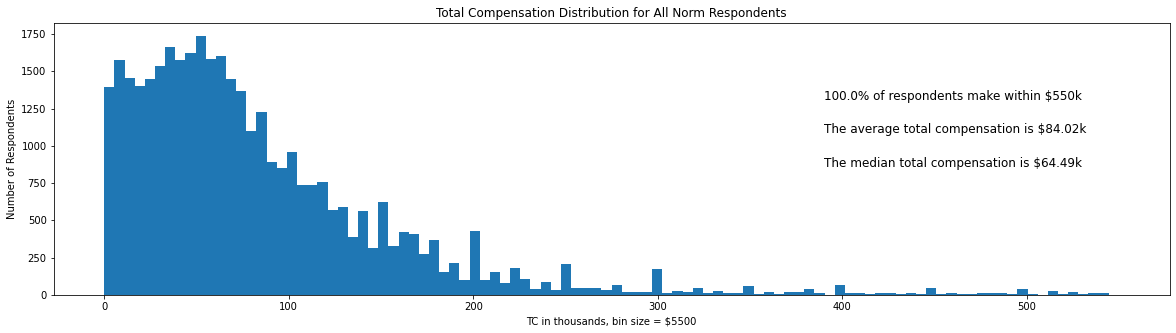

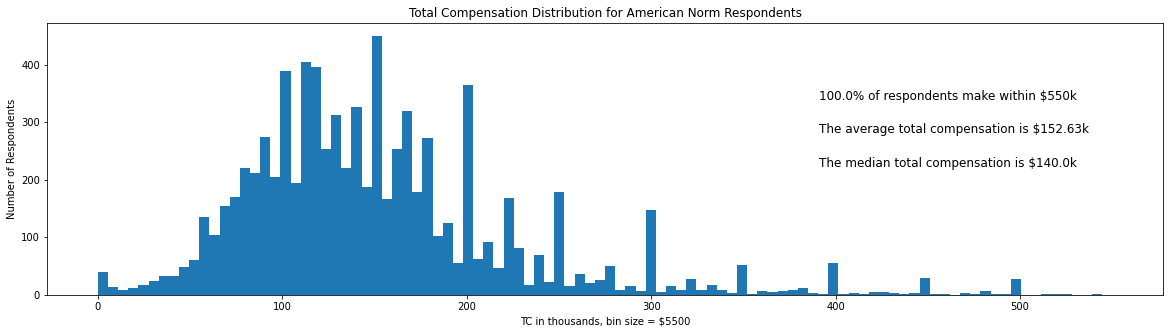

In [76]:
america_norm = (norm[norm['Country'] == 'United States of America'])
visualize_salary(norm, 'Total Compensation Distribution for All Norm Respondents')
visualize_salary(america_norm, 'Total Compensation Distribution for American Norm Respondents')


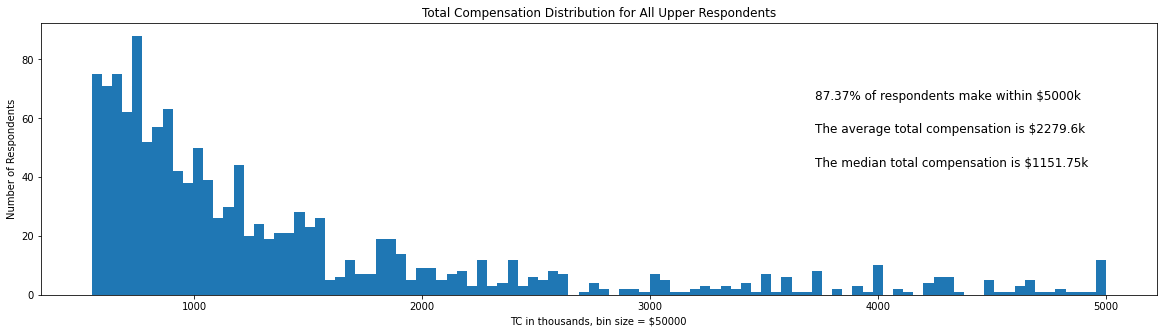

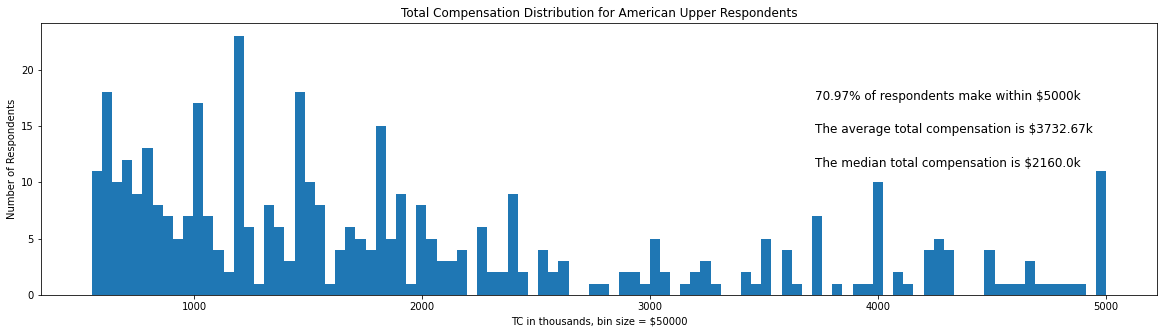

In [77]:
america_upper = (upper[upper['Country'] == 'United States of America'])
visualize_salary(upper, 'Total Compensation Distribution for All Upper Respondents', minSalary = 550_000, maxSalary = 5_000_000)
visualize_salary(america_upper, 'Total Compensation Distribution for American Upper Respondents', minSalary = 550_000, maxSalary = 5_000_000)

## Visualization by Gender

### Pruning

Since the 'In your own words' option doesn't save what the respondent elaborated with for privacy reasons, we will drop this option from each respondent's selection. If this results in an empty Gender field, we'll change it to NaN.

In [ ]:
#Warning! In-place!
def prune_gender(dataframe):
  print('Before pruning \'in your own words\' responses')
  print(dataframe['Gender'].unique())
  dataframe['Gender'].replace(inplace = True, regex = True, to_replace = ['Or, in your own words:;', 'Or, in your own words:'], value = '')
  dataframe['Gender'].replace(inplace = True, to_replace = 'Man;', value = 'Man') #Special case
  dataframe['Gender'].replace(inplace = True, to_replace = '', value = np.NaN)
  print('\n\n\nAfter pruning')
  print(dataframe['Gender'].unique())
  print('\n\n\nDropping ' + str(dataframe['Gender'].isna().sum()) + ' null values for the Gender field out of ' + str(dataframe['Gender'].shape[0]))
  dataframe.dropna(subset = ['Gender'], inplace = True)

  men = dataframe[dataframe['Gender'].str.contains('Man')]
  women = dataframe[dataframe['Gender'].str.contains('Woman')]
  nb = dataframe[dataframe['Gender'].str.contains('Non-binary')]
  undisclosed = dataframe[dataframe['Gender'].str.contains('Prefer not to say')]
  return men, women, nb, undisclosed


In [ ]:
print('Pruning the main dataset')
norm_men, norm_women, norm_nb, norm_und = prune_gender(norm)
print('Pruning the upper earners')
upper_men, upper_women, upper_nb, upper_und = prune_gender(upper)
norms = (norm_men, norm_women, norm_nb, norm_und)
uppers = (upper_men, upper_women, upper_nb, upper_und)

Pruning the main dataset
Before pruning 'in your own words' responses
['Man' 'Woman' 'Prefer not to say'
 'Man;Non-binary, genderqueer, or gender non-conforming'
 'Non-binary, genderqueer, or gender non-conforming'
 'Or, in your own words:' nan
 'Or, in your own words:;Non-binary, genderqueer, or gender non-conforming'
 'Woman;Non-binary, genderqueer, or gender non-conforming'
 'Man;Woman;Non-binary, genderqueer, or gender non-conforming'
 'Man;Or, in your own words:;Woman;Non-binary, genderqueer, or gender non-conforming'
 'Man;Or, in your own words:'
 'Or, in your own words:;Woman;Non-binary, genderqueer, or gender non-conforming'
 'Man;Woman' 'Or, in your own words:;Woman'
 'Man;Or, in your own words:;Non-binary, genderqueer, or gender non-conforming']



After pruning
['Man' 'Woman' 'Prefer not to say'
 'Man;Non-binary, genderqueer, or gender non-conforming'
 'Non-binary, genderqueer, or gender non-conforming' nan
 'Woman;Non-binary, genderqueer, or gender non-conforming'
 'Man;Wom

In [ ]:
def graph_by_gender(dataset, title, color, maxSalary, print_range = False, minSalary = 0, scaleSuffix = 'k', scaleFactor = 1_000):
  stepNum = 101
  graphBins = np.linspace(minSalary/scaleFactor, maxSalary/scaleFactor, stepNum)
  fig, ax = plt.subplots(figsize = (20, 5))
  ax.set_xlabel('Total Compensation in thousands, bin size = $' + str(int((maxSalary - minSalary) / (stepNum - 1))), fontsize = 'large')
  ax.set_ylabel('Number of Respondents', fontsize = 'large')
  ax.set_title(title, fontsize = 'large')
  percent = 100 * dataset[dataset[target] <= maxSalary].shape[0] / dataset[target].shape[0]
  percent = round(percent, 2)
  outsideRange = str(percent) + "% of this subset make within " + str(int(maxSalary / scaleFactor)) + scaleSuffix
  average = "The average total compensation is $" + str(round(dataset[target].mean() / scaleFactor, 2)) + scaleSuffix
  median = "The median total compensation is $" + str(round(dataset[target].median() / scaleFactor, 2)) + scaleSuffix
  debug = []
  if (print_range):
    ax.annotate(outsideRange, xy = (graphBins[0],0), textcoords = 'figure fraction', xytext = (0.725, 0.7), fontsize = 'large')
  ax.annotate(average, xy = (graphBins[0],0), textcoords = 'figure fraction', xytext = (0.725, 0.6), fontsize = 'large')
  ax.annotate(median, xy = (graphBins[0],0), textcoords = 'figure fraction', xytext = (0.725, 0.5), fontsize = 'large')
  ax.hist(dataset[target] / scaleFactor, bins = graphBins, color = color)

### Total Compensation by Gender

When considering those who make less than \$550k, the TC distribution follows a similar shape amongst the genders, but the average TC of the male group was 6.4% higher than the average TC for the female group. When looking at those making above $550k, the tables turn; women make 13.2% more than the men within this earnings bracket. Based on these figures, high-earning women are out-earning their male peers.

Concerning the sample size, it should be said that there were only 56 women who reported making above \$550k in the survey, while there were 1391 such men. And while this sample size is low, the proportion of women to men among this earnings cohort is only one percent point lower than among the under $550k cohort (more on this in the Gender Distribution section).

Lastly, these figures are only applicable when dividing solely by gender. There was no further dilineation among country, years of professional experience, age, ethnicity, etc.

#### Norm Dataset

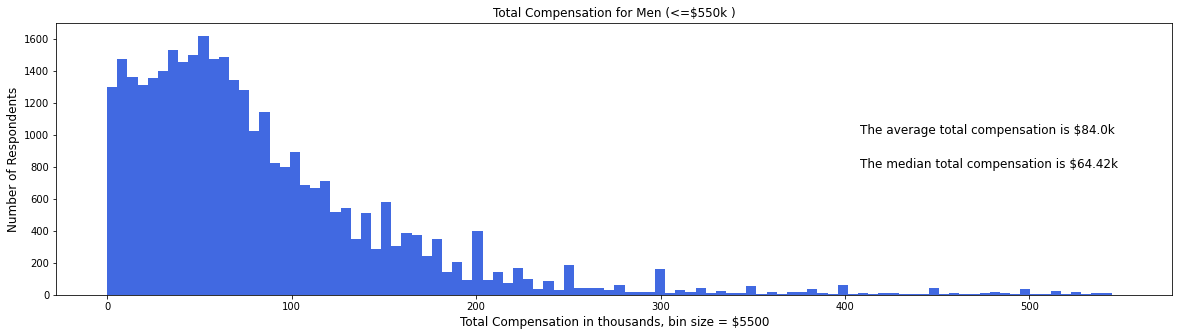

In [ ]:
graph_by_gender(norm_men, 'Total Compensation for Men (<=$' + str(int(high_target / 1000)) + 'k )', 'royalblue', high_target)

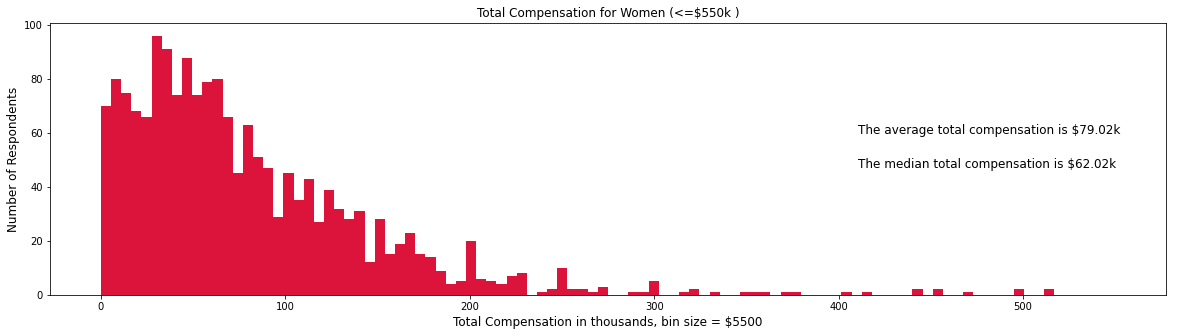

In [ ]:
graph_by_gender(norm_women, 'Total Compensation for Women (<=$' + str(int(high_target / 1000)) + 'k )', 'crimson', high_target)


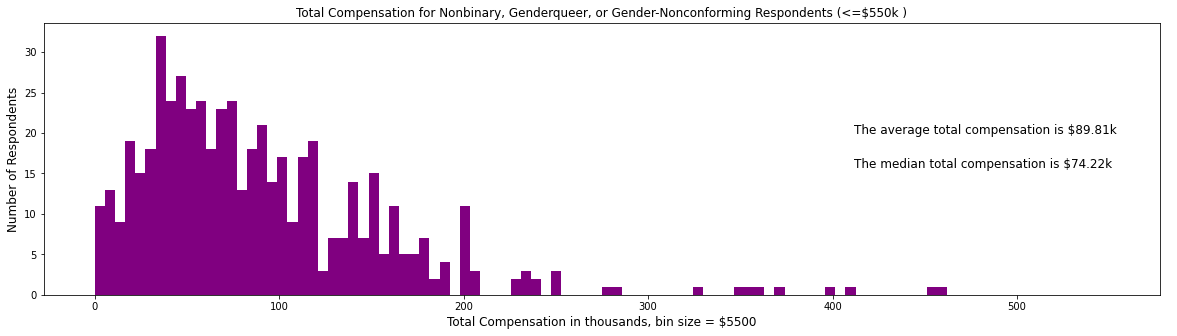

In [ ]:
graph_by_gender(norm_nb, 'Total Compensation for Nonbinary, Genderqueer, or Gender-Nonconforming Respondents (<=$' + str(int(high_target / 1000)) + 'k )', 'Purple', high_target)

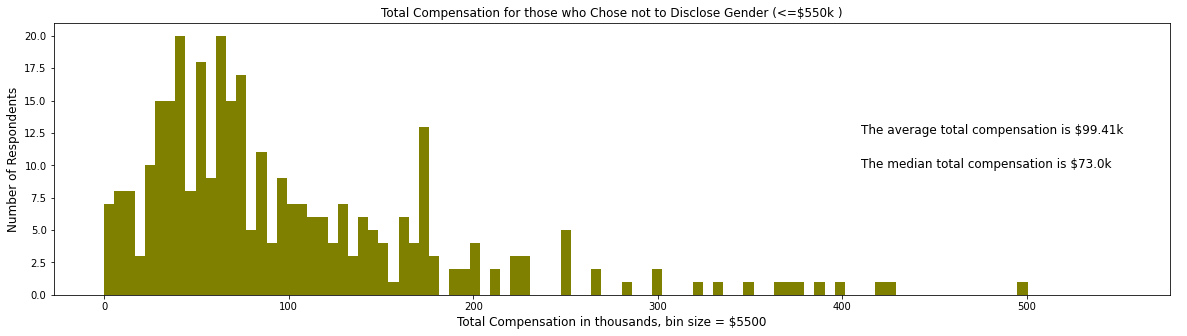

In [ ]:
graph_by_gender(norm_und, 'Total Compensation for those who Chose not to Disclose Gender (<=$' + str(int(high_target / 1000)) + 'k )', 'olive', high_target)

#### Upper Dataset

1399


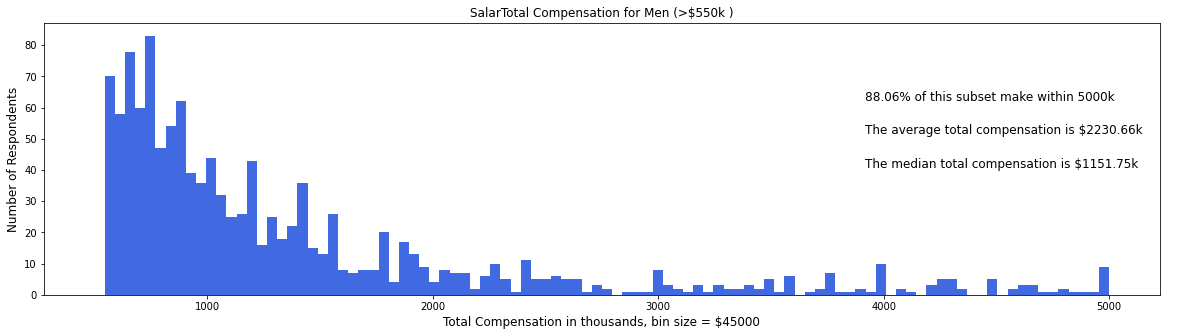

In [ ]:
graph_by_gender(upper_men, 'SalarTotal Compensation for Men (>$' + str(int(high_target / 1000)) + 'k )', 'royalblue', maxSalary = 5_000_000, minSalary = 500_000, print_range = True)
print(upper_men.shape[0])

56


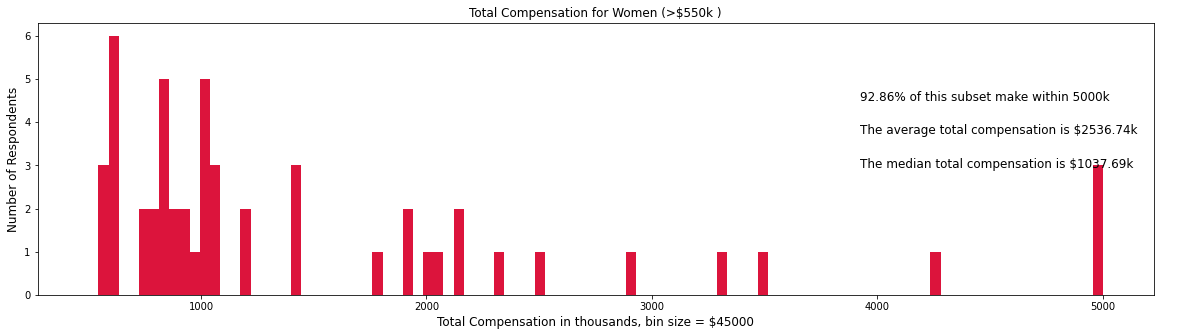

In [ ]:
graph_by_gender(upper_women, 'Total Compensation for Women (>$' + str(int(high_target / 1000)) + 'k )', 'crimson', maxSalary = 5_000_000, minSalary = 500_000, print_range = True)
print(upper_women.shape[0])

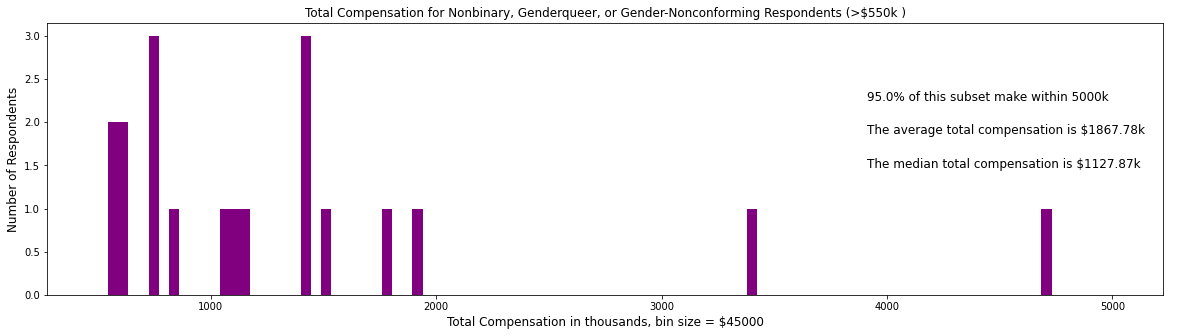

In [ ]:
graph_by_gender(upper_nb, 'Total Compensation for Nonbinary, Genderqueer, or Gender-Nonconforming Respondents (>$' + str(int(high_target / 1000)) + 'k )', 'Purple', maxSalary = 5_000_000, minSalary = 500_000, print_range = True)

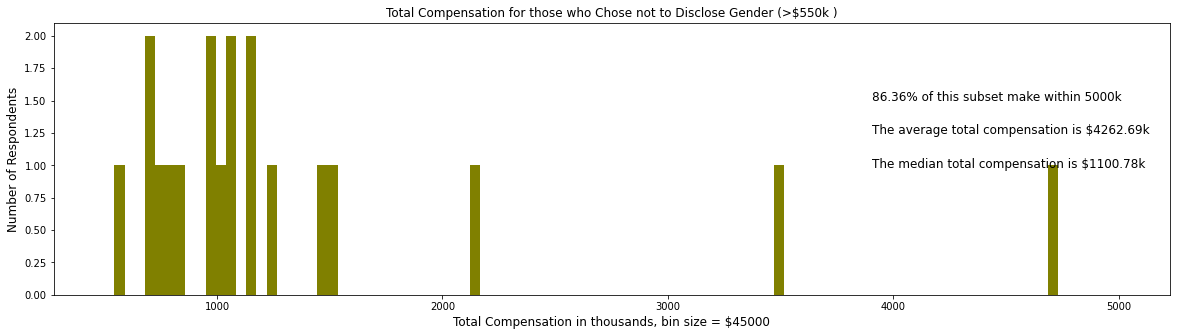

In [ ]:
graph_by_gender(upper_und, 'Total Compensation for those who Chose not to Disclose Gender (>$' + str(int(high_target / 1000)) + 'k )', 'olive', maxSalary = 5_000_000, minSalary = 500_000, print_range = True)

### Gender Distribution

The survey respondents are overwhelmingly male. The gender distribution is essentially identically between the two earnings cohorts: when comparing the ratio of men to women between the two earnings cohorts, women are 5.12% of men among those making less than $550k, and 4.06% of men among those making more. 

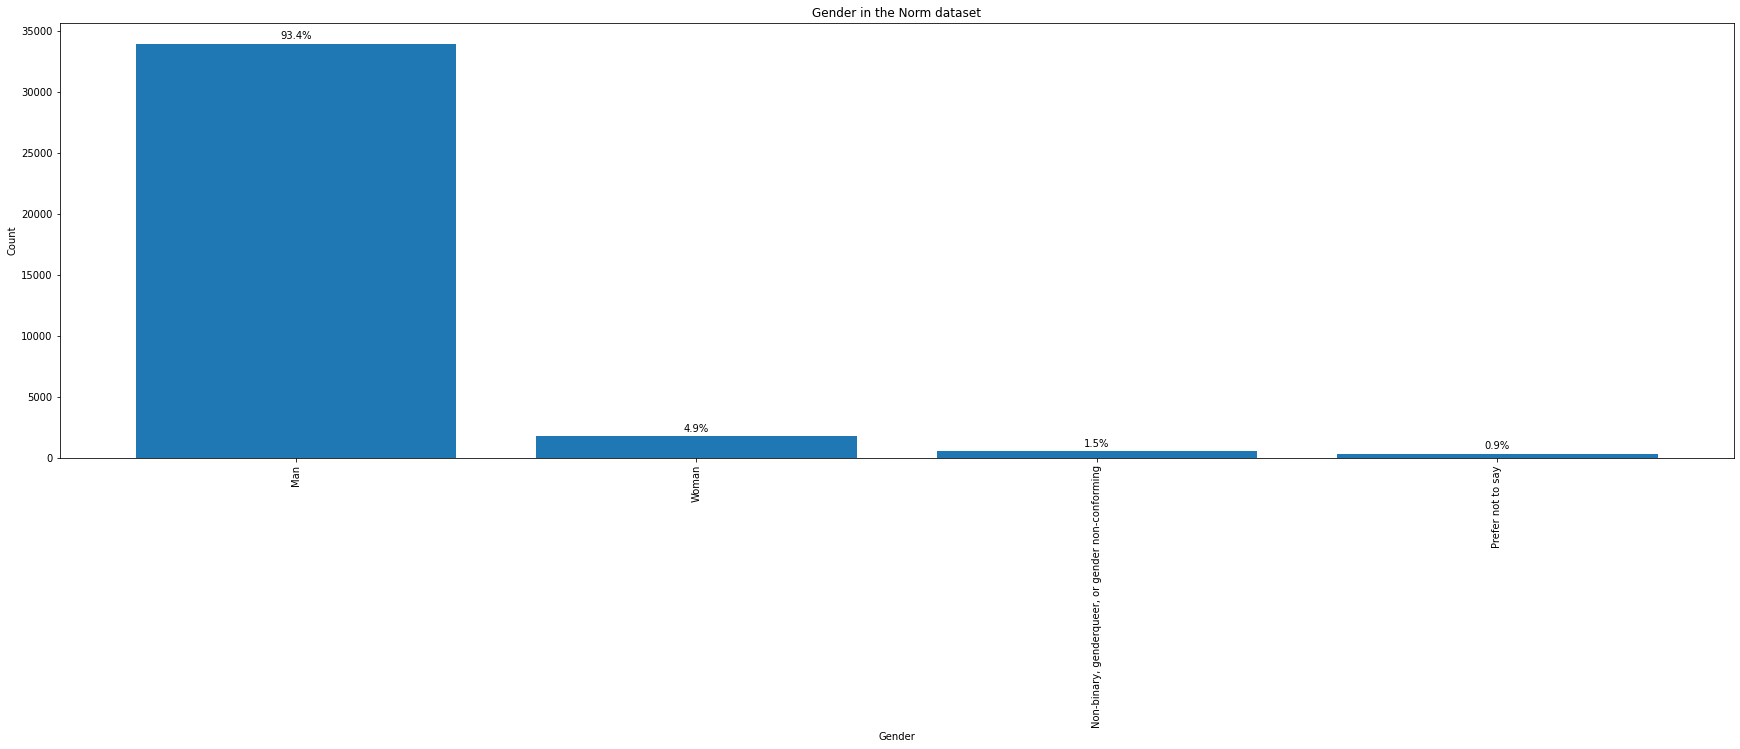

In [ ]:
make_bar_graph(norm, 'Gender', 'Gender in the Norm dataset',  'Gender',  'Count')

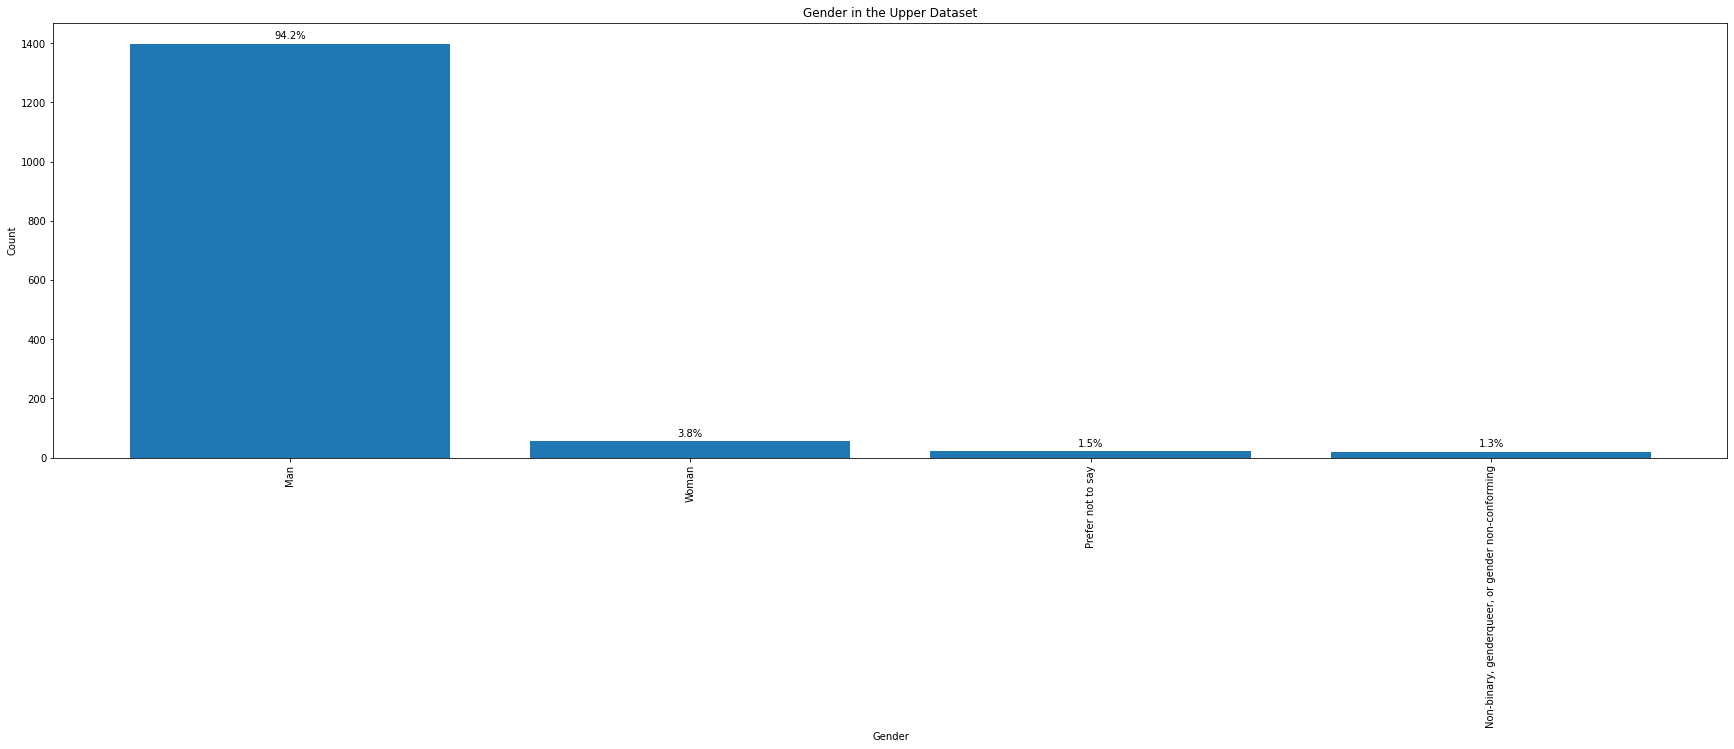

In [ ]:
make_bar_graph(upper, 'Gender', 'Gender in the Upper Dataset',  'Gender',  'Count')

## Age Distribution

Almost half each dataset is between 25 and 34 years old, with  over 70% of each dataset being 25 and 44 years old. The upper dataset is ever so slightly older when considering the 3rd largest age group; for the norm dataset, this is 18-24, while for the upper dataset it's 45-54.

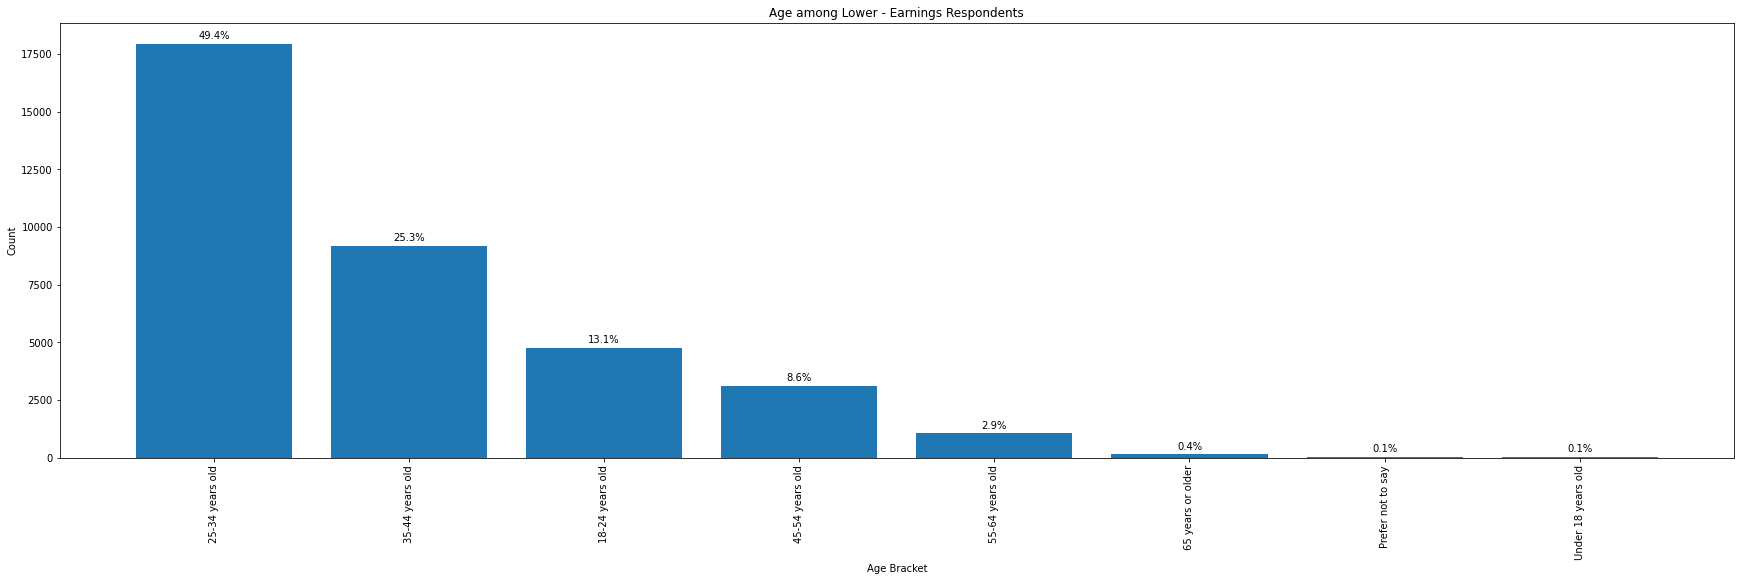

In [ ]:
make_bar_graph(norm, 'Age', 'Age among Lower - Earnings Respondents',  'Age Bracket',  'Count')

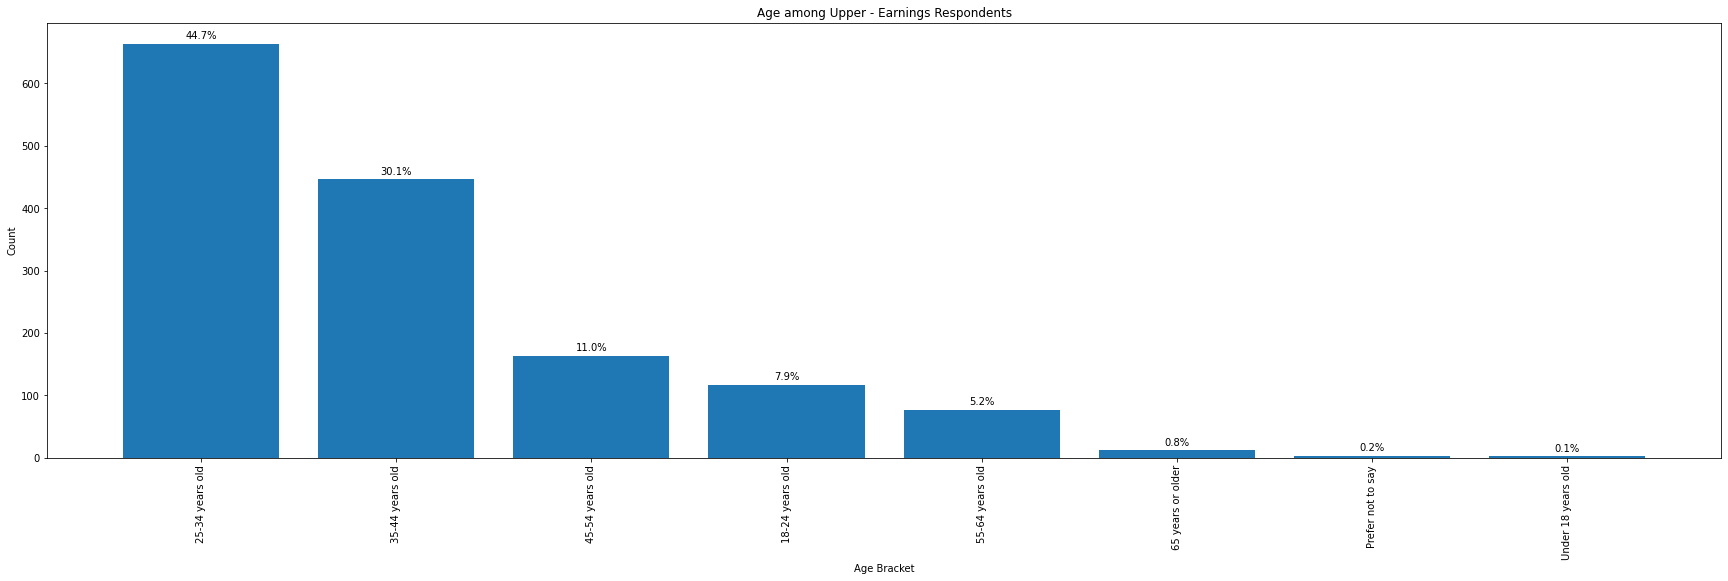

In [ ]:
make_bar_graph(upper, 'Age', 'Age among Upper - Earnings Respondents',  'Age Bracket',  'Count')

## Sexuality Distribution

Each dataset has an essentially identical distribution by sexuality. 87% of both datasets identified as heterosexual.

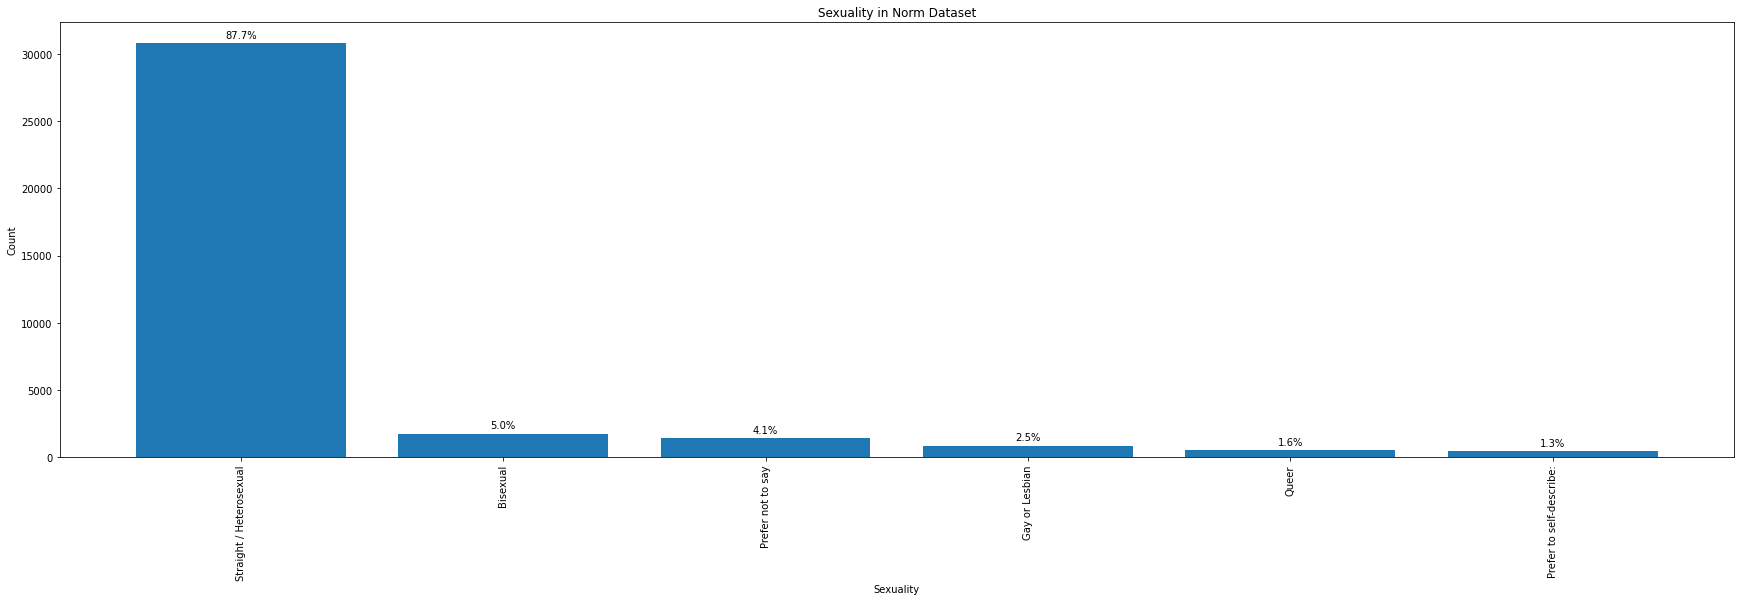

In [ ]:
make_bar_graph(norm, 'Sexuality', 'Sexuality in Norm Dataset',  'Sexuality',  'Count')

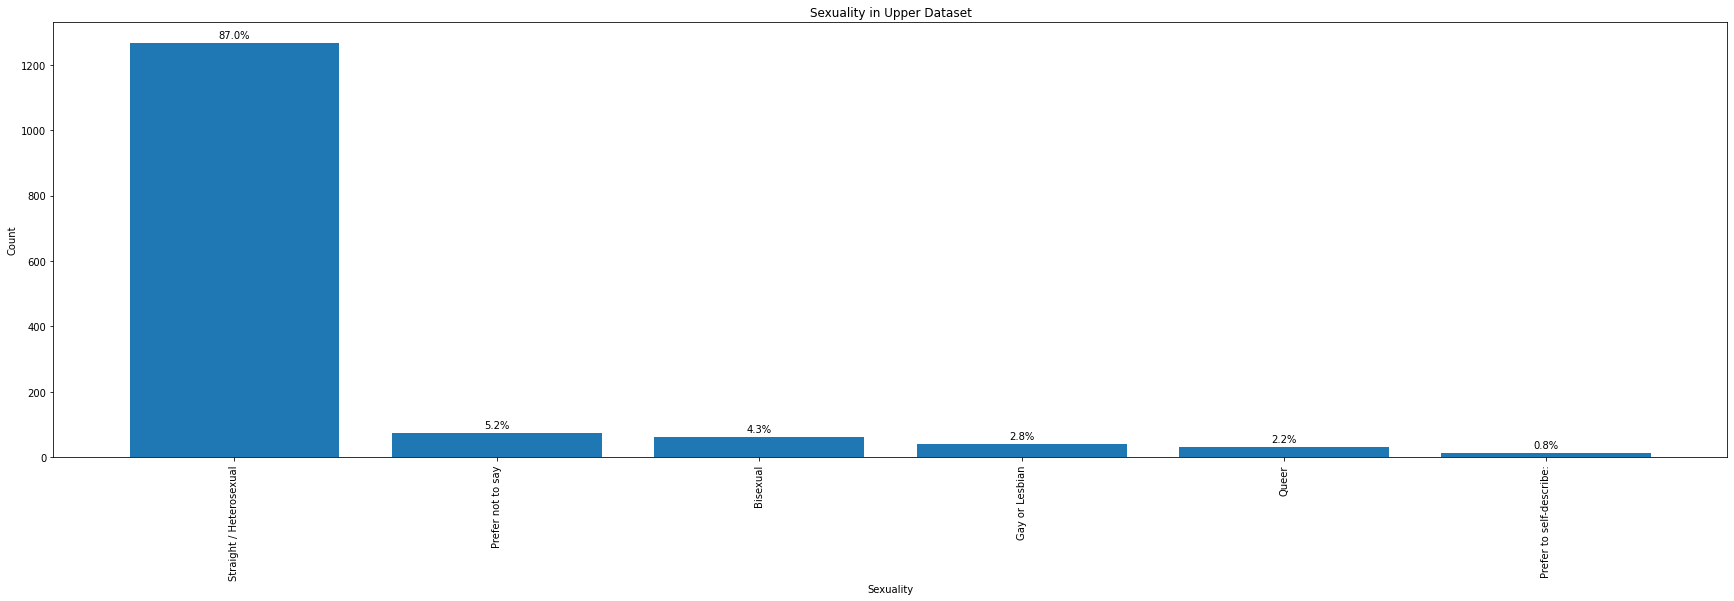

In [ ]:
make_bar_graph(upper, 'Sexuality', 'Sexuality in Upper Dataset',  'Sexuality',  'Count')

## Transgender Distriubtion

96-97% of respondents identified as not being transgender across both datasets.

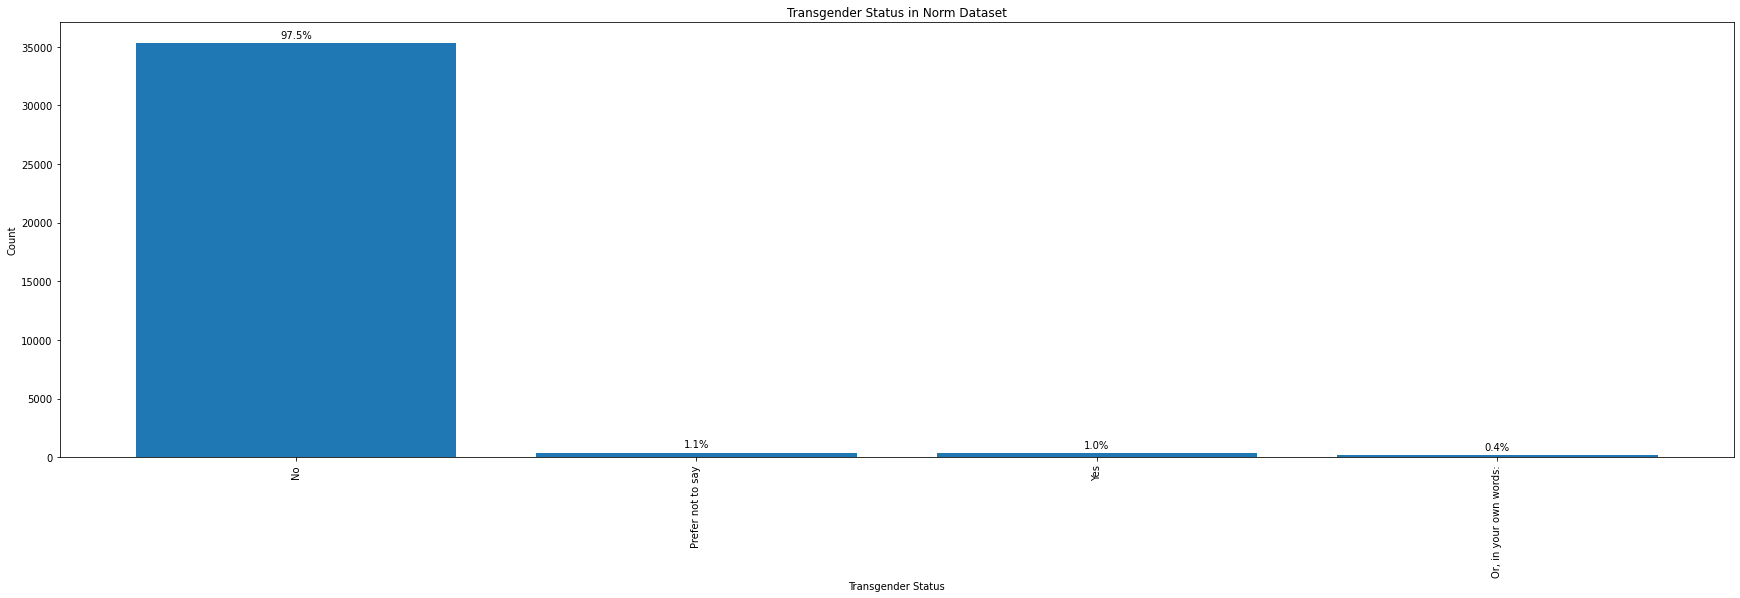

In [ ]:
make_bar_graph(norm, 'Trans', 'Transgender Status in Norm Dataset', 'Transgender Status', 'Count')

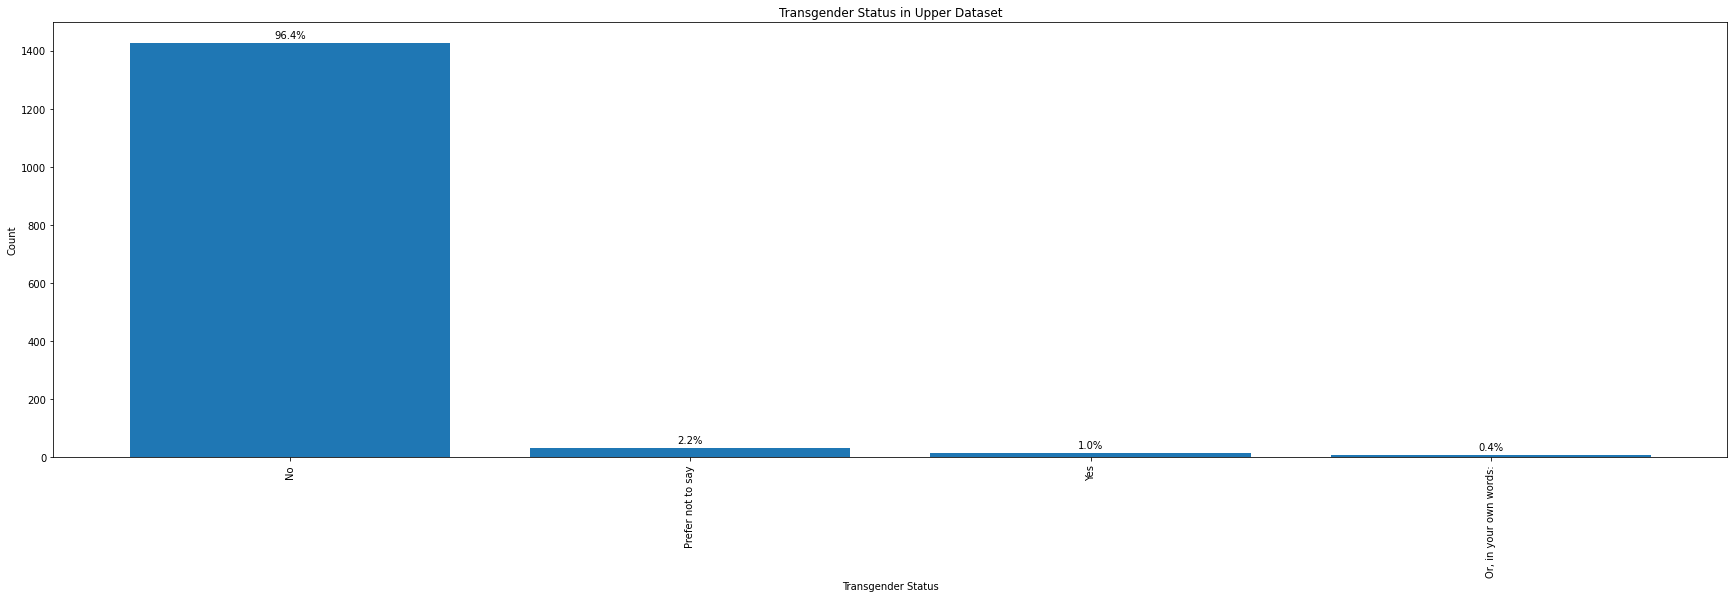

In [ ]:
make_bar_graph(upper, 'Trans', 'Transgender Status in Upper Dataset', 'Transgender Status', 'Count')

## Ethnicity Distribution and Total Compensation by Ethnicity

There were lots of options the respondent could've picked between when it comes to ethnicity. And, like with gender, the respondent is able to pick as many options as they feel apply. With so many individual options to represent, making a graph for each one is a tall order. Instead, the dataset will be split into different dataframes of respondents whose ethnicity *includes* each individual option, and the mean and median total compensation for each will be displayed. Remember, the survey respondents come from across the world and have their respective currencies converted into USD, and features like gender aren't dilineated.

In [ ]:
def ethnicity_combos(dataframe):
  uniques = dataframe['Ethnicity'].unique()
  atoms = get_atoms(dataframe, 'Ethnicity')
  print(f'There are a total of {len(uniques)} unique combinations chosen from {len(atoms)} individual options')

In [ ]:
ethnicity_combos(norm)

There are a total of 686 unique combinations chosen from 25 individual options


In [ ]:
ethnicity_combos(upper)

There are a total of 111 unique combinations chosen from 25 individual options


In [ ]:
def salary_by_ethnicity(dataframe):
  atoms = get_atoms(dataframe, 'Ethnicity')
  noNaNs = dataframe.dropna(subset = ['Ethnicity'], inplace = False)
  for atom in atoms:
    if 'Indigenous' in atom: #Special case, is 0 otherwise somehow
      atom = 'Indigenous'
    ethnicity = noNaNs[noNaNs['Ethnicity'].str.contains(atom)]
    number = ethnicity.shape[0]
    percent = (round(100.0 * number / noNaNs.shape[0], 2))
    print(f'{number} respondents include {atom} among their ethnicities, or {percent}%')
    print(f'The average total compensation among this ethnicity is ${round(ethnicity[target].mean() / 1000, 2)}k, and the median is ${round(ethnicity[target].median() / 1000, 2)}k\n')

In [ ]:
salary_by_ethnicity(norm)

16451 respondents include White among their ethnicities, or 45.73%
The average total compensation among this ethnicity is $105.7k, and the median is $87.95k

14364 respondents include European among their ethnicities, or 39.93%
The average total compensation among this ethnicity is $74.14k, and the median is $58.87k

1347 respondents include North American among their ethnicities, or 3.74%
The average total compensation among this ethnicity is $125.1k, and the median is $115.0k

569 respondents include Prefer not to say among their ethnicities, or 1.58%
The average total compensation among this ethnicity is $102.09k, and the median is $79.98k

1313 respondents include Middle Eastern among their ethnicities, or 3.65%
The average total compensation among this ethnicity is $74.6k, and the median is $59.57k

935 respondents include African among their ethnicities, or 2.6%
The average total compensation among this ethnicity is $45.6k, and the median is $26.56k

3601 respondents include Asia

In [ ]:
salary_by_ethnicity(upper)

835 respondents include White among their ethnicities, or 56.8%
The average total compensation among this ethnicity is $2588.67k, and the median is $1281.52k

33 respondents include Prefer not to say among their ethnicities, or 2.24%
The average total compensation among this ethnicity is $2971.64k, and the median is $1194.68k

533 respondents include European among their ethnicities, or 36.26%
The average total compensation among this ethnicity is $1438.47k, and the median is $921.4k

6 respondents include I don't know among their ethnicities, or 0.41%
The average total compensation among this ethnicity is $1110.64k, and the median is $1153.37k

59 respondents include Hispanic or Latino/a among their ethnicities, or 4.01%
The average total compensation among this ethnicity is $4601.85k, and the median is $1401.26k

23 respondents include Or, in your own words: among their ethnicities, or 1.56%
The average total compensation among this ethnicity is $2029.16k, and the median is $1369.31k

## DevType Distribution

Across both datasets, the most popular roles were front end, back end, and full stack. There aren't any significant differences in the distributions of developer type between the two datasets.

Remember, since one person could pick multiple titles, the sum of these percentages won't be 100%! 

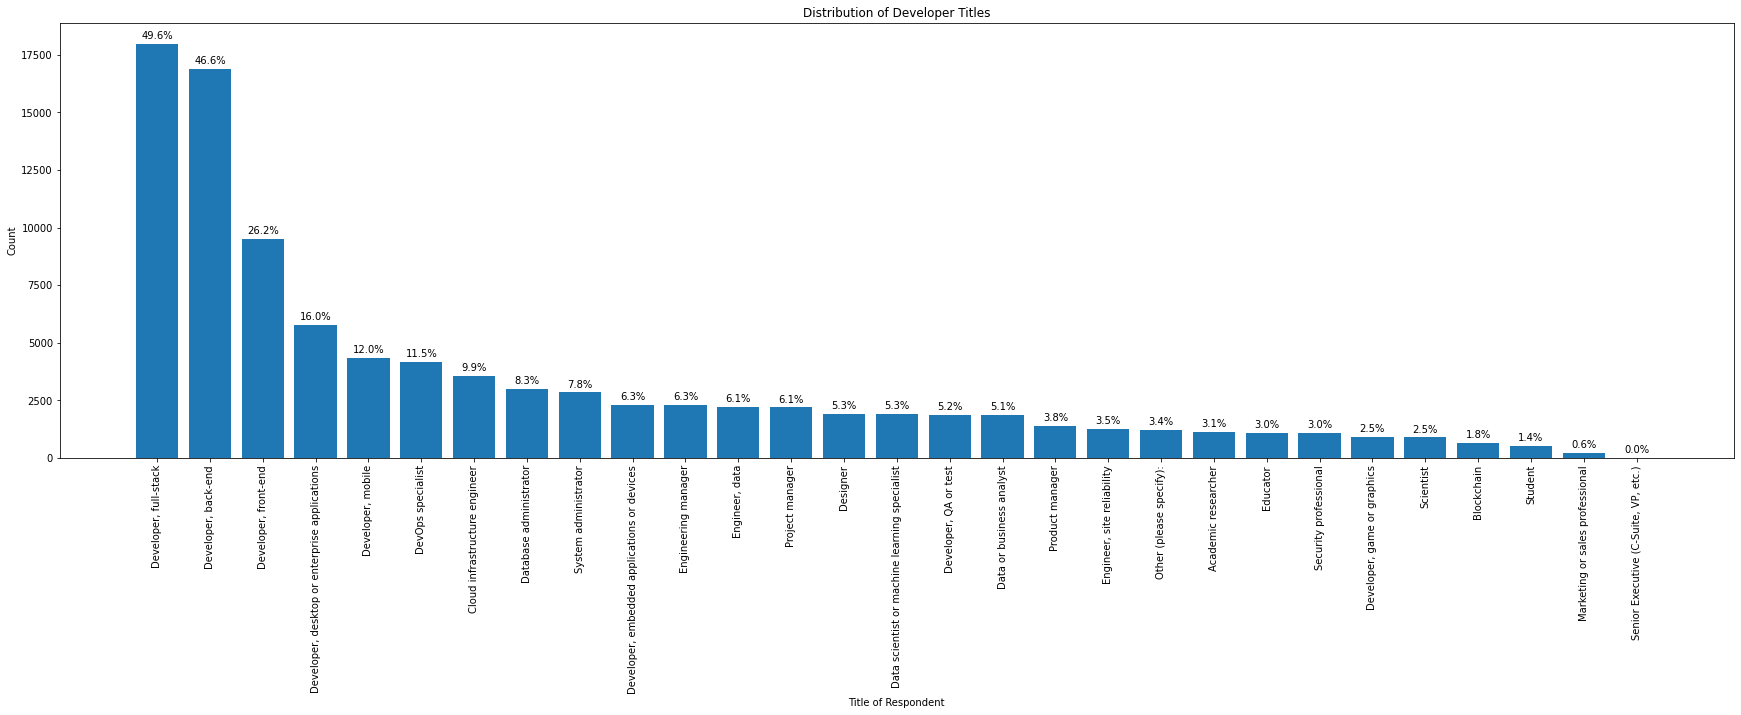

In [ ]:
make_bar_graph(norm, 'DevType', 'Distribution of Developer Titles', 'Title of Respondent', 'Count')

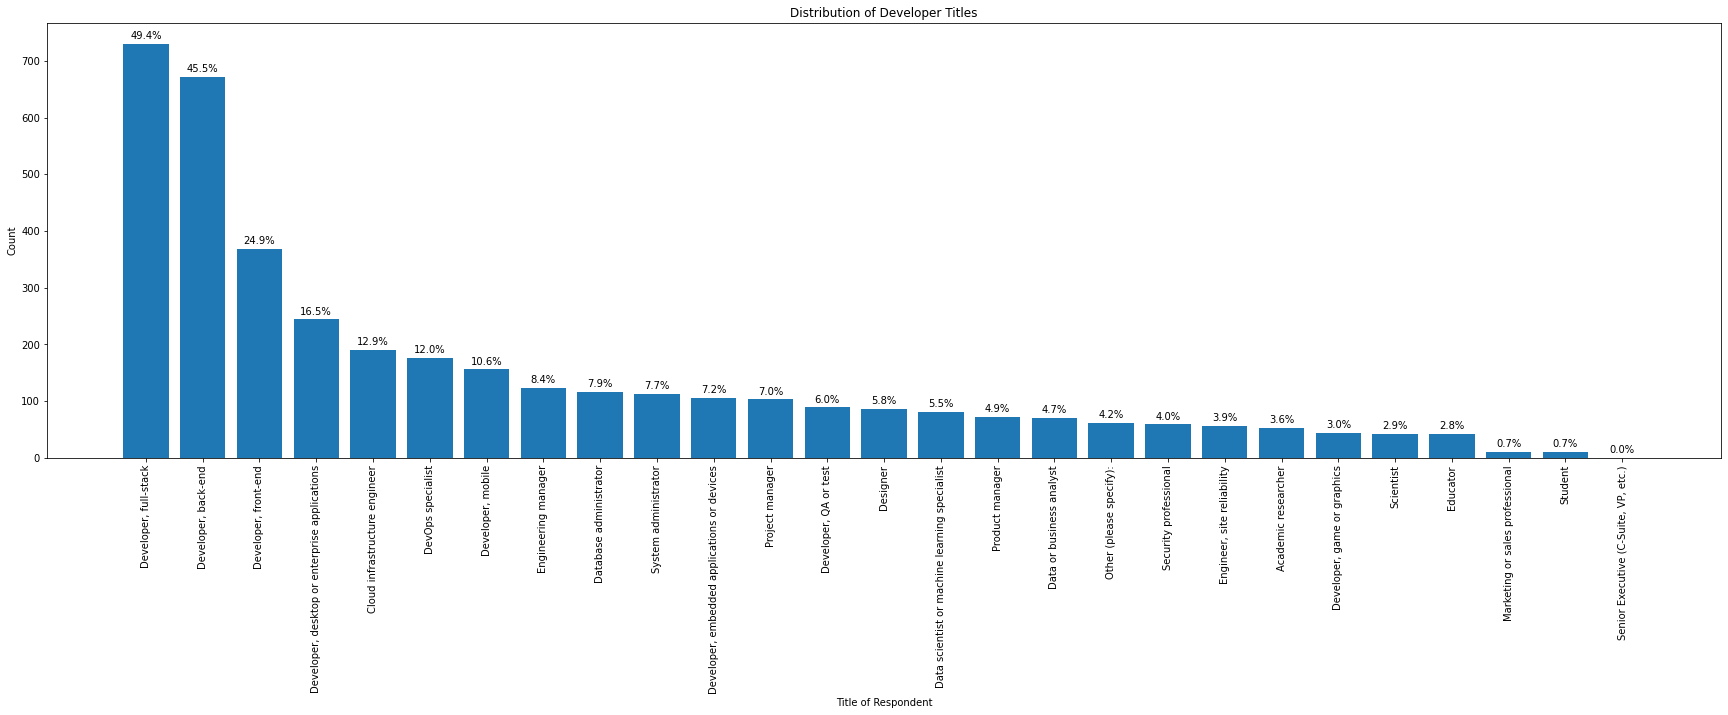

In [ ]:
make_bar_graph(upper, 'DevType', 'Distribution of Developer Titles', 'Title of Respondent', 'Count')

## Work Experience Distribtion

The most frequent number of years worked for each dataset is 3 years, at about 8% of respondents for both. However, for the next 3 most common responses to the question, the upper earners have been in the field a bit longer. The average for the 2nd-4th most frequent responses in the norm dataset is 2.67 years, while the average for the upper dataset is 7 years.

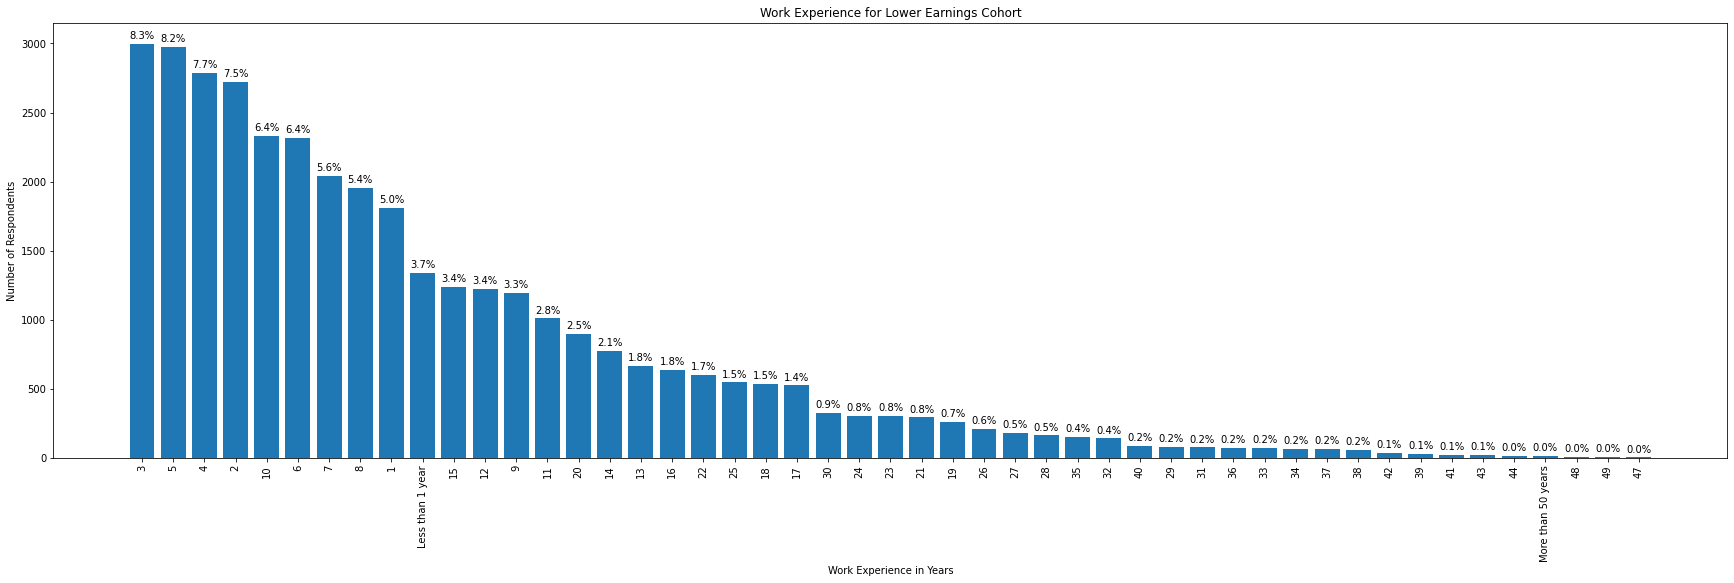

In [ ]:
workexp_bar_graph(norm, 'Work Experience for Lower Earnings Cohort')

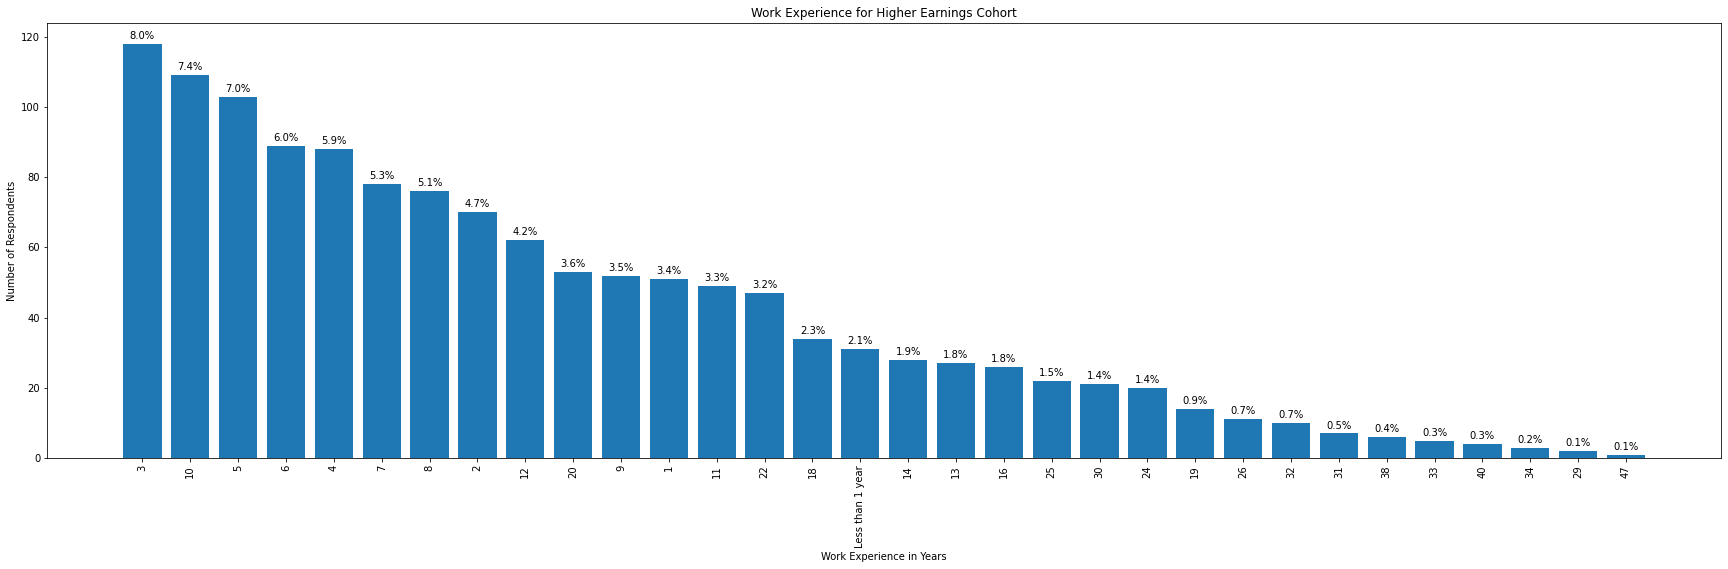

In [ ]:
workexp_bar_graph(upper, 'Work Experience for Higher Earnings Cohort')

# Data Preprocessing

## Encoding

As with most datasets, we arrive at the issue of encoding. Simple one-hot encoding results in such a monstrous amount of features, Google Colab runs out of RAM and interrupts execution. Even if we were to one-hot encode along the atoms of each choice and have them be indepententally applicable, instead of making a new feature for each unique combination of atoms selected, this could add dozens and dozens of new features per categorical feature. Going from about 20 features to hundreds of features is clearly not the greatest for dimensionality!

Enter [target encoding](https://sci-hub.se/10.1145/507533.507538) (a less academic explanation is [here](https://maxhalford.github.io/blog/target-encoding/)\). Essentially, each category within a feature is replaced by a blend of the mean target variable among all records that have that category in that feature  and the overall mean target.

For example, if someone indicates their `Sexuality` as `bisexual`, this categorical string is replaced by a blend of the mean total compensation among all those who indicate their sexuality as solely `bisexual`  and the overall total compensation average. If their response was `bisexual;straight`, it would be encoded with a blend of the average total compensation of all those who chose `bisexual;straight` as their sexuality and the average overall total compensation.

Target encoding has the benefit of creating no new features; not a single extra column is added to the data frame. And, as icing on the cake, target encoding can impute missing values as well. If someone skipped the question asking for their `Sexuality`, their `NaN` value would be replaced with a blend of the average total compensation of everyone else who skipped that question and the average overall total compensation.

### Encoding Helper Functions

In [ ]:
def get_x_and_y(dataframe):
  copy = dataframe.copy()
  y = copy.pop(target)
  return copy, y

In [ ]:
#Non-destructive function to return a target-encoded dataframe and its encoder
def sample_target_encoding(dataframe):
  encoder = TargetEncoder()
  train_x, train_y = get_x_and_y(dataframe)
  encoder.fit(train_x, train_y)
  # Some encoders behave differently on whether y is given or not. This is mainly due to regularisation in order to avoid overfitting. 
  # On training data transform should be called with y, on test data without.
  transformed = encoder.transform(train_x, train_y)
  return transformed, encoder, train_y

In [ ]:
# Non-destructive function to return a leave-one-out-encoded dataframe, its encoder, and the target variable
def sample_loo_encoding(dataframe):
  encoder = LeaveOneOutEncoder(sigma = 0.325)
  train_x, train_y = get_x_and_y(dataframe)
  encoder.fit(train_x, train_y)
  # Some encoders behave differently on whether y is given or not. This is mainly due to regularisation in order to avoid overfitting. 
  # On training data transform should be called with y, on test data without.
  transformed = encoder.transform(train_x, train_y)
  return transformed, encoder, train_y

### Target Encoding Example

In [ ]:
norm.head(3)

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,ConvertedCompYearly
2,"I am not primarily a developer, but I write co...",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5,Data scientist or machine learning specialist;...,20 to 99 employees,United Kingdom of Great Britain and Northern I...,C#;C++;HTML/CSS;JavaScript;Python,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",40205.0
3,I am a developer by profession,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17,"Developer, full-stack",100 to 499 employees,Israel,C#;JavaScript;SQL;TypeScript,35-44 years old,Man,No,Straight / Heterosexual,White,None of the above,None of the above,215232.0
8,I am a developer by profession,I don’t code outside of work,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Developer, back-end",I don’t know,Netherlands,NaN,25-34 years old,Woman,No,Prefer to self-describe:,European,"Or, in your own words:","Or, in your own words:",49056.0


In [ ]:
transformed_norm, norm_encoder, dummy = sample_target_encoding(norm)
transformed_norm.head(3)

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth
2,85157.930151,84684.994045,87721.992246,73828.552234,83939.251892,73464.130599,97646.708971,49029.553034,75740.716458,84002.650336,83942.488389,77511.083837,122910.109436,84334.575834,87053.071605
3,83835.597295,90191.400825,83893.269900,106496.921905,80638.816925,84106.693148,130191.030848,85528.757009,102158.350637,84002.650336,83942.488389,84745.940987,122910.109436,84334.575834,82266.094900
8,83835.597295,90191.400825,87721.992246,81739.716875,86792.693637,67247.641283,76260.394676,71512.375000,75740.716458,77940.992788,83942.488389,71946.766154,71312.570971,83674.522634,76182.926829


### Leave-One-Out Encoding Example

Leave One Out encoding is essentially target encoding except that the record currently being encoded is not used in the encoding calculation, and the SKLearn implementation has support for introducing some Gaussian randomness into the result. We will be using Leave One Out encoding as this Gaussian randomness is [said to improve performance](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html):

`The default is to not add noise, but that leads to significantly suboptimal results.`

In [ ]:
transformed_norm, norm_encoder, norm_y = sample_loo_encoding(norm)
transformed_norm.head(3)

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth
2,102536.888429,99088.544539,43267.320861,99432.799411,45723.491252,89025.399073,119969.191714,29500.809681,55911.902142,66088.334085,92917.020161,84569.846709,110067.212420,83092.204033,70826.608187
3,109874.077336,89141.876838,74878.233319,85818.840748,94988.449969,114869.235411,149200.047652,75342.953529,135435.756791,70778.561764,59816.105163,86504.316970,44571.123558,97586.102723,94901.470793
8,71103.440438,60496.403624,175071.790589,51496.538692,72986.547387,43335.085711,56192.667086,98491.371539,64077.069298,97789.237191,84610.559386,67438.973803,67051.980969,90585.886869,65082.379343


## Correlations

Now that everything in the dataframe has been encoded and imputed, we can look at correlations. `Ethnicity`, `YearsCodePro`, `Age`, and especially `Country` seem to be the highest predictors among the `norm` dataset, whereas the `upper` dataset doesn't seem to have any strong correlations except for `Country`, which has a weaker correlation of about 0.25 compared to the norm dataset's 0.45

### Norm Correlations

In [ ]:
transformed_norm[target] = norm_y
transformed_norm.corr()

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,ConvertedCompYearly
MainBranch,1.000000,0.000646,0.006689,-0.005872,-0.003810,-0.002449,-0.008037,-0.001702,0.006019,0.004609,-0.000065,-0.003323,-0.001312,0.003694,0.001555,0.000899
CodingActivities,0.000646,1.000000,-0.004463,0.022095,0.025459,-0.000237,0.037251,0.019098,0.006202,-0.001307,0.006786,0.001413,0.028954,0.003992,0.010047,0.051641
EdLevel,0.006689,-0.004463,1.000000,0.013169,0.009029,0.003600,0.009223,0.004387,0.016516,-0.006957,0.005770,-0.003497,0.002500,0.009074,0.003793,0.020131
YearsCodePro,-0.005872,0.022095,0.013169,1.000000,0.041761,0.023985,0.114297,0.027657,0.283359,0.001090,0.001103,-0.001952,0.074806,0.003186,-0.001854,0.209970
DevType,-0.003810,0.025459,0.009029,0.041761,1.000000,0.019163,0.052560,0.036661,0.035775,0.007648,-0.012542,0.000652,0.029152,-0.004519,-0.004219,0.102321
OrgSize,-0.002449,-0.000237,0.003600,0.023985,0.019163,1.000000,0.060978,0.021814,0.023473,0.005616,-0.006688,0.001968,0.024131,-0.002752,-0.000328,0.091121
Country,-0.008037,0.037251,0.009223,0.114297,0.052560,0.060978,1.000000,0.053568,0.108237,0.006294,-0.003990,0.002638,0.366391,-0.000689,0.034117,0.472586
LanguageHaveWorkedWith,-0.001702,0.019098,0.004387,0.027657,0.036661,0.021814,0.053568,1.000000,0.014335,0.004934,-0.000542,0.003830,0.033103,-0.003712,0.007529,0.077126
Age,0.006019,0.006202,0.016516,0.283359,0.035775,0.023473,0.108237,0.014335,1.000000,0.016689,-0.002507,-0.006687,0.061012,-0.000045,-0.007723,0.161379
Gender,0.004609,-0.001307,-0.006957,0.001090,0.007648,0.005616,0.006294,0.004934,0.016689,1.000000,0.003455,-0.002419,0.004776,0.001022,0.003622,0.012160


### Upper Correlations

In [ ]:
transformed_upper, upper_encoder, upper_y = sample_loo_encoding(upper)
transformed_upper[target] = upper_y
transformed_upper.corr()

,MainBranch,CodingActivities,EdLevel,YearsCodePro,DevType,OrgSize,Country,LanguageHaveWorkedWith,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,ConvertedCompYearly
MainBranch,1.000000,-0.007652,-0.015433,0.002213,0.002775,0.013376,-0.005496,0.048748,0.033913,-0.033047,-0.059554,-0.003740,-0.053494,-0.017610,-0.000631,0.012420
CodingActivities,-0.007652,1.000000,0.031578,-0.032287,0.063440,-0.021138,0.029841,0.044079,-0.020025,0.007669,-0.027514,-0.013515,-0.040773,0.009133,0.027996,0.032347
EdLevel,-0.015433,0.031578,1.000000,0.007522,0.046743,0.002449,0.064089,-0.010852,-0.030018,0.009377,0.017544,-0.029441,-0.009914,-0.012782,0.024995,0.047031
YearsCodePro,0.002213,-0.032287,0.007522,1.000000,-0.004926,-0.043568,0.033058,-0.007416,-0.041554,0.017153,0.001041,-0.027511,0.015058,0.017287,0.014642,-0.016460
DevType,0.002775,0.063440,0.046743,-0.004926,1.000000,-0.016126,-0.030956,-0.043073,-0.012243,0.005697,0.012555,0.018286,0.010557,0.003411,-0.035962,0.061577
OrgSize,0.013376,-0.021138,0.002449,-0.043568,-0.016126,1.000000,0.059027,0.029575,-0.014063,0.009707,0.024026,-0.010433,0.009160,0.026371,-0.007790,0.031140
Country,-0.005496,0.029841,0.064089,0.033058,-0.030956,0.059027,1.000000,0.081919,0.000843,0.016445,0.026464,-0.009235,0.151977,-0.083556,-0.018015,0.219665
LanguageHaveWorkedWith,0.048748,0.044079,-0.010852,-0.007416,-0.043073,0.029575,0.081919,1.000000,0.023609,0.009572,-0.016567,0.034916,-0.036847,-0.031095,0.002488,-0.009708
Age,0.033913,-0.020025,-0.030018,-0.041554,-0.012243,-0.014063,0.000843,0.023609,1.000000,-0.034829,0.019617,0.017055,0.030196,0.020807,0.028178,0.007908
Gender,-0.033047,0.007669,0.009377,0.017153,0.005697,0.009707,0.016445,0.009572,-0.034829,1.000000,0.053795,-0.023549,-0.006738,0.022826,0.019967,-0.014297


## Scaling and Principle Component Analysis

Before starting with the neural net, we'll create a function that, given a dataframe, will encode it, scale it, and perform PCA on it, returning data_x and data_y as tensors. This will fully preprocess the data and format it in a way that makes running it through the neural net easier.

In [ ]:
# Dimensionality reduction. Has a bit more logic so is its own function
def pca_data(data_x, verbose, variance, argpca):
  pca = argpca
  if pca == None:  # Need to create pca object
    if variance == -1:
      pca = PCA()  # -1, do default args
    else:
      # Specified variance, create to keep that amount
      pca = PCA(n_components = variance, svd_solver = 'full')
    # For new pca object, need to fit
    pca = pca.fit(data_x)
  oldSize = data_x.shape[1]
  # If argpca wasn't None, will just transform witout fitting
  result = pca.transform(data_x)
  newSize = result.shape[1]
  if verbose >= 2:
    print(f'Reduced data from {oldSize} features to {newSize} features')
  return result, pca

This is the function we'll use. Given a dataset, an amount of variance to keep during PCA, and whether to print progress messages, the function will return the x data, the y data, and the encoder, scaler, and pca object used for preprocessing. For training, one can pass in `None` for `argencoder`, `argscaler`, and `argpca` and then pass in the objects created come evaluation and it'll use those pre-fit objects.

Scaling is done using the default SKLearn StandardScaler and PCA is done with the SKLearn PCA object. The target variable can be scaled down to its natural log if `scale_target == True` in an attempt to keep the jump from scaled independent variables to a very large dependent variable smaller. If this is done, the exponential function will be applied to the RMSE before it is printed out.

In [ ]:
# Non-destructive function that uses Leave One Out encoding, a standard sklearn scaler, and PCA to preprocess a dataframe and return as a tensor_x and tensor_y
def encode_normalize_pca(data, scale_target, argencoder, argscaler, argpca, verbose = True, variance = -1):
  sigma = 0.1
  warnings.filterwarnings("ignore")
  if verbose >= 2:
    print('Beginning encoding', end = '')
    if argencoder == None:
      print(' of training data')
    else:
      print(' of test data')

  encoder = argencoder
  data_x, data_y = get_x_and_y(data)
  data_y = data_y.to_numpy()
  if encoder == None: # Need to make an encoder for this data, training data
    encoder = LeaveOneOutEncoder(sigma = sigma)
    encoder.fit(data_x, data_y)
  data_x = encoder.transform(data_x)
  if verbose >= 2:
    print("Encoding done")
  if verbose >= 2:
    print('Beginning scaling')

  scaler = argscaler
  if scaler == None: # Need to make the scaler, training data
    scaler = StandardScaler()
    scaler = scaler.fit(data_x)
  data_x = scaler.transform(data_x)
  if scale_target:
    data_y = np.log(data_y)
    if verbose >= 2:
      print('Main scaling done, scaling target down by natural logarithm')
  if verbose >= 2:
    print('Scaling done')
    print('Beginning PCA')
  
  data_x, pca = pca_data(data_x, verbose, variance, argpca)
  if verbose >= 2:
    print('PCA done\n')
  result_x = torch.tensor(data_x).float()
  result_y = torch.tensor(data_y).float()
  return result_x, result_y, encoder, scaler, pca

# Neural Net Regression

## Training Functions

### Epoch Training (Deprecated)

This training function trains the net the old fashioned way, running through every record in the training set once for every epoch in chunks specified by the batch size. This function has lower performance than the random sampling train function and is thus deprecated.

In [ ]:
# # Deprecated for its inferior performance, but kept around for giggles
# def epoch_train(net, train_x, train_y, test_x, test_y, bat_size, epochs, begin, learning_rate, verbose):
#   num_prints = 5
#   net = net.train()  # Set training mode
#   loss_func = torch.nn.MSELoss()  # Mean squared error
#   optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#   num_records = len(train_x)
#   batches = math.ceil(num_records / bat_size)
#   if verbose >= 2:
#     print(f'Running a total of {batches*epochs} batches and {epochs} epochs')
#   for epoch in range(epochs):
#     # Shuffle time!
#     shuffling = torch.randperm(len(train_x)) # Shuffling key
#     epoch_train_x = train_x[shuffling]
#     epoch_train_y = train_y[shuffling]
#     batches_x = torch.split(epoch_train_x, bat_size) # `N / bat_size` tensors of size `bat_size` x `features` each
#     batches_y = torch.split(epoch_train_y, bat_size)
#     for batch in range(len(batches_x)):
#       optimizer.zero_grad() # "Sets the gradients of all optimized torch.Tensor s to zero." Resets for next grad descent?
#       oupt = net(batches_x[batch]) # Forward pass
#       loss_obj = loss_func(oupt, batches_y[batch])
#       loss_obj.backward()  # Compute gradients
#       optimizer.step()     # Update weights and biases, backward pass
#     if epoch % (epochs // num_prints) == 0: # prints num_prints times
#       currentTime = time.time()
#       elapsed = currentTime-begin
#       net = net.eval()
#       r2, rmse = r2_and_rmse(net, test_x, test_y)
#       net = net.train()
#       if verbose >= 2:
#         print("epoch = %6d" % epoch, end="\t")
#         print("epoch loss = %7.0f   " % loss_obj.item(), end="\t")
#         print(f"R2 = {round(r2, 4)}\tRMSE = ${round(rmse / 1000, 3)}k   ", end = "\t")
#         print(f'\tTime elapsed: {int(elapsed // 60)}m {int(elapsed % 60)}s ', end = '\t')
#         print(f"{100 * epoch // epochs}% done")
#   currentTime = time.time()
#   elapsed = currentTime-begin
#   if verbose >= 2:
#     print(f"\nTraining complete. Time elapsed: {int(elapsed // 60)}m {int(elapsed % 60)}s")
#   return net

### Random Sampling Training

Random sampling training does things a little differently from the usual method. With this method, an epoch of training is done by feeding in a batch of randomly-selected records then running back propogation a total of `num_records // batch_size` times. This method resulted in a slightly better RMSE and is thus the main way of training in this project.

In [ ]:
def random_sampling_train(train, test, hidden_layers, hidden_layer_nodes, bat_size, epochs, begin, learning_rate, verbose):
  scale_target = True
  num_prints = 5
  # A previous data leak had the data already preprocessed. Doing here means each train set is self-contained
  train_x, train_y, encoder, scaler, pca = encode_normalize_pca(train, scale_target, None, None, None, verbose = verbose, variance = variance)
  test_x, test_y, encoder, scaler, pca = encode_normalize_pca(test, scale_target, encoder, scaler, pca, verbose = verbose)
  features = len(train_x[0])
  nodes_per_layer = hidden_layer_nodes
  if nodes_per_layer == None:
    nodes_per_layer = max(((features * 2) // 3), 1)
    if verbose >= 2:
      print(f'Using {nodes_per_layer} nodes per layer for this fold\'s model')
  if verbose >= 2:
    print('Creating neural net for this fold')
  net = NeuralNet(features, hidden_layers, nodes_per_layer)  # Create and set training mode
  net = net.train()
  loss_func = torch.nn.MSELoss()  # Mean squared error
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  n_items = len(train_x)
  batches_per_epoch = n_items // bat_size
  max_batches = epochs * batches_per_epoch
  if verbose >= 2:
    print(f'Running a total of {max_batches} batches')
  for b in range(max_batches):
    curr_bat = np.random.choice(n_items, bat_size,
      replace=False)
    X = torch.Tensor(train_x[curr_bat])
    Y = torch.Tensor(train_y[curr_bat]).view(bat_size,1)
    optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt, Y)
    loss_obj.backward()
    optimizer.step()
    if b % (max_batches // num_prints) == 0: # prints num_prints times
      net = net.eval()
      r2, rmse = r2_and_rmse(net, test_x, test_y)
      net = net.train()
      currentTime = time.time()
      elapsed = currentTime-begin
      if verbose >= 2:
        print("batch = %6d" % b, end="\t")
        print("batch loss = %3.4f   " % loss_obj.item(), end="\t")
        print(f"R2 = {round(r2, 4)}\tRMSE = ${round(rmse / 1000, 3)}k   ", end = "\t")
        print(f'\tTime elapsed: {int(elapsed // 60)}m {int(elapsed % 60)}s ', end = '\t')
        print(f"{100 * b // max_batches}% done")
  if verbose >= 2:
    currentTime = time.time()
    elapsed = currentTime-begin
    print(f"\nTraining complete. Time elapsed: {int(elapsed // 60)}m {int(elapsed % 60)}s")
  return net, test_x, test_y

## Helper Functions

These functions help to format the data into the correct type, make and choose partitions, etc.

In [ ]:
#Non-destructive way to convert a whole Pandas dataframe into a data_x and a data_y in tensor form
def get_tensors(data):
  copy = data.copy()
  pandasY = copy.pop(target)
  resultX = torch.tensor(copy.values)
  resultY = torch.tensor(pandasY.values)
  return resultX, resultY

In [ ]:
# Will return an array of K equally-sized partitions of dataframe. 
# Last partition may have anywhere up to K extra records 
def partition_dataframe(dataframe, folds):
  per_fold = norm.shape[0] // folds
  copy = norm.copy()
  partitions = []
  partition = copy.sample(n=per_fold)
  partitions.append(partition)
  copy = copy.drop(partition.index)
  for fold in range(folds-2):
    partition = copy.sample(n=per_fold)
    partitions.append(partition)
    copy = copy.drop(partition.index)
  partitions.append(copy)
  return partitions

In [ ]:
def train_and_test_sets(splits, test_index):
  asList = splits.copy()
  test = asList.pop(test_index)
  train = pd.concat(asList, ignore_index = True)
  return train, test

In [ ]:
def shuffle_datasets(set1, set2):
  if len(set1) != len(set2):
    return None, None
  shuffling = torch.randperm(len(set1)) # Shuffling key
  result1 = set1[shuffling]
  result2 = set2[shuffling]
  return result1, result2

## Evaluation Functions

The neural net will be evaluated off of two metrics, the Root Mean Squared Error and the R<sup>2</sup> score. 

RMSE is essentially how off the neural net is for each guess on average, and is in the unit of the target variable AKA dollars. This is our primary metric as it is an easily interpretable and intuitive way to judge the model. We want this value to be as low as possible. A RMSE of $0 means our model perfectly guesses total compensation every time.

The R<sup>2</sup> score, or coefficient of determination, is a unitless metric of how much of the variance in the dependent variable is present within variation of the independent variables and can be anywhere from 0 to 1, inclusive. We're technically using an adjusted R<sup>2</sup> score for this problem that shrinks the value by the number of features used due to a phenomenon where adding more features can only improve the R<sup>2</sup> value of a model. We want this value to be as close to one as possible. An R<sup>2</sup> value of 1.0 means the features included can perfectly explain the variance in total compensation. 

In [ ]:
def root_mean_squared_error(N, yPreds, yReals):
  sum = torch.sum(torch.square(yPreds - yReals))
  result = torch.sqrt(sum / N)
  return result.item()

In [ ]:
# K is the number of features, actual are the real test_y values, and yHats are the predictions
def r2_score(K, actual, yHats):
  N = len(actual)
  yActual = torch.Tensor(actual)  # actual as 1-d Tensor
  yRealMean = torch.mean(yActual)
  yHatMean = torch.mean(yHats)
  numerator = (torch.sum(torch.square(yHats - yHatMean))).item()
  denominator = (torch.sum(torch.square(yActual - yRealMean))).item()
  if denominator == 0:
    print(f'denominator is 0 for R2 score! Returning 1')
    return 1
  rSquared =  numerator / denominator
  numerator = (1 - rSquared) * (N - 1)
  denominator = N - K - 1
  rSquaredAdjusted = 1 - (numerator/denominator)
  return rSquaredAdjusted

In [ ]:
# To be called while training
def r2_and_rmse(net, test_x, test_y):
  scale_target = True
  features = len(test_x[0])
  N = len(test_y)
  net = net.eval()  # set eval mode
  preds = net(torch.Tensor(test_x)).view(N) # all predicted as 1-d Tensor
  # print(f'Making preds for eval, here\'s what we\'ve got\n{preds}')
  newPreds = preds
  scaled_y = test_y
  if scale_target == True:
    newPreds = torch.exp(preds)
    scaled_y = torch.exp(test_y)
  R2 = r2_score(features, scaled_y,newPreds)
  rmse = root_mean_squared_error(N, newPreds, scaled_y)
  absolute_diffs = newPreds - scaled_y
  # print(f'\nHow much each prediction overshoots the target: \n{absolute_diffs}')
  # print(f'Overall, the average overshoot is ${round(torch.mean(absolute_diffs).item() / 1000, 3)}k')
  return R2, rmse

# Wrapper for above, to be called in cross_validate
def eval(net, test_x, test_y):
  r2, rmse = r2_and_rmse(net, test_x, test_y)
  print(f"Model has R2 = {round(r2, 4)} and RMSE = ${round(rmse / 1000, 3)}k\n") # Rounding RMSE to 3 is nearest dollar, 5 is nearest cent
  return r2, rmse

## Neural Net Class

The neural net! It has a configurable number of nodes per hidden layer and a configurable number of hidden layers, although always at least one. Each hidden layer will have the same number of nodes, and the model will output a single continuous value. Nodes have their weights initialized according to Xavier intialization and their biases initialized to 0.

In [ ]:
# Will always have at least one hidden layer
class NeuralNet(torch.nn.Module):

  def __init__(self, num_inputs, hidden_layers, hidden_layer_nodes):
    super(NeuralNet, self).__init__()
    self.hiddenLayers = torch.nn.ModuleList()
    firstHidden = torch.nn.Linear(num_inputs, hidden_layer_nodes)
    self.hiddenLayers.append(firstHidden) #maps input to the first hidden layer
    torch.nn.init.xavier_uniform_(self.hiddenLayers[0].weight) # Randomizes weights for this mapping via the Xavier/Glodot intitialization technique
    torch.nn.init.zeros_(self.hiddenLayers[0].bias) # Sets the biases to 0 for this mapping

    for layer in range(1, hidden_layers):  # start at 1 since the initial input layer maps to a hidden layer
      self.hiddenLayers.append(torch.nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
      torch.nn.init.xavier_uniform_(self.hiddenLayers[layer].weight)
      torch.nn.init.zeros_(self.hiddenLayers[layer].bias)
    
    self.hiddenLayers.append(torch.nn.Linear(hidden_layer_nodes, 1)) # Output layer
    torch.nn.init.xavier_uniform_(self.hiddenLayers[-1].weight)
    torch.nn.init.zeros_(self.hiddenLayers[-1].bias)

  def forward(self, x):
    # print(f'{x} is being fed forward')
    activation_func = torch.nn.LeakyReLU()
    z = activation_func(self.hiddenLayers[0](x))
    # print(f'fed forward,\n{x}\n is now {z}\n')
    for layer in range(1, len(self.hiddenLayers) - 1): # Start from 1 since (input->1st_hidden) is done outside of the loop
      z = activation_func(self.hiddenLayers[layer](z))
      # print(f'fed forward, z is now {z}\n')
    # Last layer will be done outside the loop as an identity/ReLU
    lastFunc = torch.nn.Identity()
    z = lastFunc(self.hiddenLayers[-1](z))
    # print(f'last feed forward, output is {z}\n\n')
    return z

## Cross Validate Model

This function is the main heavy lifter of the entire notebook. Given some hyperparameters and a dataframe, it will return the Root Mean Squared Error and the R<sup>2</sup> score across each fold and over the entire cross validation. The process goes like this:

*    The data is split into K folds by randomly sampling `data.shape[0] // partitions` records from `data`
*    The neural net object is initialized according to the given hyperparameters
*    The neural net is trained, giving printouts for the model's performance according to the given fold's test set 5 times each fold
     *    If `train_by_epoch` is set to true, the neural net is trained by shuffling the training and test data, feeding in `batch_size` records, and running backpropagation until all records in the dataset have been fed through. This process is repeated `epoch` times
     *    If `train_by_epoch` is set to false, the neural net is trained by feeding in `batch_size` random records then running back propogation a total of `epochs * num_records // batch_size` times
*    At the end of training, the Root Mean Squared Error and R<sup>2</sup> scores are printed and returned

In [ ]:
def cross_validate_model(data, dataset_name, hidden_layers = 3, train_by_epoch = False, nodes_per_layer = None, bat_size = 10, variance = 0.95, epochs = 100, partitions = 5, learning_rate = 0.01, verbose = 2):
  begin = time.time()
  copy = data.copy()
  r_squared = 0.0
  rmse = 0.0
  # Split into k folds
  folds = partition_dataframe(copy, partitions)
  for partition in range(partitions):
    if verbose >= 2:
      print(f'Beginning fold {partition + 1} of {partitions}')
    train, test = train_and_test_sets(folds, partition)
    net = None
    test_x = None
    test_y = None
    # Begin training
    if train_by_epoch:
      if verbose >= 2:
        print('Training by epoch not currently implemented')
      error = 0 / 0
      epoch_train(train_x, train_y, test_x, test_y, bat_size, epochs, begin, learning_rate, verbose)
    else:
      if verbose >= 2:
        print('Training with random sampling')
      net, test_x, test_y = random_sampling_train(train, test, hidden_layers, nodes_per_layer, bat_size, epochs, begin, learning_rate, verbose)
    r_squareAdd, rmseAdd = eval(net, test_x, test_y)
    r_squared = r_squared + (r_squareAdd / partitions)
    rmse = rmse + (rmseAdd / partitions)
  currentTime = time.time()
  elapsed = currentTime-begin
  if verbose >= 1:
    nodes_printout = nodes_per_layer
    if nodes_printout == None:
      nodes_printout = '(features * 2) // 3'
    print(f'Validation complete! ({int(elapsed // 60)}m {int(elapsed % 60)}s elapsed)')
    print(f"Cross-validated model with {partitions} partitions on dataset {dataset_name} has:\nR2 = {round(r_squared, 4)}\t RMSE = ${round(rmse / 1000, 2)}k")
    print(f'hidden_layers = {hidden_layers}, bat_size = {bat_size}, nodes_per_layer = {nodes_printout}, variance = {variance}, epochs = {epochs}, learning_rate = {learning_rate}')
  return r_squared, rmse

## Running Cross Validation

The "standard" hyperparameters used were:

*    3 hidden layers
*    8 nodes per hidden layer
*    A batch size of 10
*    100 epochs
*    Preserving 95% of the variance during PCA
*    Cross validating with k = 5
*    A learning rate of 0.01

Deviations from these parameters didn't tend to result in significantly different results, and if they were different they were usually worse. The typical RMSE is around \$64k for both the `norm` and `upper` datasets.

In [ ]:
hidden_layers = 3
nodes_per_layer = None
bat_size = 20
epochs = 100
variance = 0.95
partitions = 5
learning_rate = 0.01
verbose = 2

rsquare, rmse = cross_validate_model(norm, 'norm', hidden_layers = hidden_layers, nodes_per_layer = nodes_per_layer, bat_size = bat_size, epochs = epochs, variance = variance, learning_rate = learning_rate, partitions = partitions, verbose = verbose)

Beginning fold 1 of 5
Training with random sampling
Beginning encoding of training data
Encoding done
Beginning scaling
Main scaling done, scaling target down by natural logarithm
Scaling done
Beginning PCA
Reduced data from 15 features to 13 features
PCA done

Beginning encoding of test data
Encoding done
Beginning scaling
Main scaling done, scaling target down by natural logarithm
Scaling done
Beginning PCA
Reduced data from 15 features to 13 features
PCA done

Using 8 nodes per layer for this fold's model
Creating neural net for this fold
Running a total of 145300 batches
batch =      0	batch loss = 115.8524   	R2 = -0.0018	RMSE = $111.386k   		Time elapsed: 0m 0s 	0% done
batch =  29060	batch loss = 0.3411   	R2 = 0.2494	RMSE = $63.372k   		Time elapsed: 0m 56s 	20% done
batch =  58120	batch loss = 0.2947   	R2 = 0.3772	RMSE = $60.708k   		Time elapsed: 1m 52s 	40% done
batch =  87180	batch loss = 0.3329   	R2 = 0.4776	RMSE = $60.594k   		Time elapsed: 2m 47s 	60% done
batch = 1162

In [ ]:
rsquare, rmse = cross_validate_model(upper, 'upper', hidden_layers = hidden_layers, nodes_per_layer = nodes_per_layer, bat_size = bat_size, epochs = epochs, variance = variance, learning_rate = learning_rate, partitions = partitions, verbose = verbose)

Beginning fold 1 of 5
Training with random sampling
Beginning encoding of training data
Encoding done
Beginning scaling
Main scaling done, scaling target down by natural logarithm
Scaling done
Beginning PCA
Reduced data from 15 features to 13 features
PCA done

Beginning encoding of test data
Encoding done
Beginning scaling
Main scaling done, scaling target down by natural logarithm
Scaling done
Beginning PCA
Reduced data from 15 features to 13 features
PCA done

Using 8 nodes per layer for this fold's model
Creating neural net for this fold
Running a total of 145300 batches
batch =      0	batch loss = 114.4373   	R2 = -0.0018	RMSE = $112.504k   		Time elapsed: 0m 0s 	0% done
batch =  29060	batch loss = 0.3532   	R2 = 0.3502	RMSE = $63.06k   		Time elapsed: 0m 56s 	20% done
batch =  58120	batch loss = 0.3071   	R2 = 0.3169	RMSE = $62.143k   		Time elapsed: 1m 52s 	40% done
batch =  87180	batch loss = 0.4449   	R2 = 0.3942	RMSE = $60.616k   		Time elapsed: 2m 48s 	60% done
batch = 11624

# Regression Trees

To get a baseline to compare to, we can use a regression tree from sklearn and see how well it predicts total compensation. We'll use a regression forest with 100 trees. The tree typically results in a RMSE of $60k.

In [ ]:
def regression_forest(data):
  start = time.time()
  sigma = 0.1
  forest = RandomForestRegressor(n_estimators = 100)
  encoder = LeaveOneOutEncoder(sigma = sigma)
  data_x = data.copy()
  data_y = data_x.pop(target)
  data_x = encoder.fit_transform(data_x, data_y)
  score = cross_validate(forest, data_x, data_y, cv=5, scoring=('r2', 'neg_root_mean_squared_error'), n_jobs = 8)
  r2 = np.array(score['test_r2']).mean()
  rmse = np.array(score['test_neg_root_mean_squared_error']).mean() * -1
  rmse = round(rmse / 1000, 3)
  end = time.time()
  runtime = round(end - start)
  print(f'R2 {r2}')
  print(f'RMSE ${rmse}k')
  print(f'Execution time {runtime // 60}m {runtime % 60}s')

In [ ]:
regression_forest(norm)

R2 0.35766776654734783
RMSE $59.911k
Execution time 3m 52s


In [ ]:
regression_forest(upper)

R2 -0.003101271693000207
RMSE $3179.269k
Execution time 0m 11s


# Results

## Analysis of RMSE

The neural net provided here performed rather well relative to the SKLearn regression forest. With a RMSE of \$62.99k, the neural net's error was only 5.1% greater than the random forest's \$59.911k. And when considering the outlier dataset, the neural net did even better; a RMSE of \$3179.269k (that's $3.1 million) from the regression forest means the neural net's \$63.96k RMSE  was **49.7 times better** than the neural net's error!

Such a RMSE for the normal dataset isn't the most impressive, as $60k is a lot of money. The same value for the outlier dataset is much more impressive, considering the average TC was \$2.2 million! If the RMSE of the regression forest is even higher than the average value of the `upper` dataset, this indicates it probably can't handle the huge range of TC as well as the neural net.


## Next Steps

Further steps would be to better visualize how the target variable is distributed across different features. While data visualization did include, for example, the % of respondents who identified as Full Stack Developers, it didn't visualize how much Full Stack Developers make on average compared to other occupations, for example.

Along with more visualization, more thorough feature engineering might yield better results. Lots of time was spent on tuning hyperparameters and making sure the neural net was functioning correctly, none of which resulted in significant improvements in performance. 

To begin, an SKLearn regression tree can be constructed on the data, and the data to be used for the neural net can be reduced down to the top N features in the tree. Imputing age, work experience, and education levels off of each other would fill NaNs without relying on target encoding to handle them. Merging similar job titles, binning work experience, binning lesser-used programming languages as 'other,' etc. are all ways to modify the data in a way to hopefully make the relationship of these features with the target variable more direct.

Of course, there might also be a possibility that the survey data is simply too unreliable to properly predict salary off of. Only after more thorough feature engineering and data preprocessing can this possibility be accepted.

# What Was Learned

Overall, I learned a great deal about every step in the data mining process. My familiarity with  Matplotlib, Pandas, and Numpy grew throughout the project. I introduced myself to and learned PyTorch well enough to create a neural net that performs about as well as a random regression forest. 

But other than raw programming skills, I learned more about some of the fundamentals and common techniques of data mining and data science. Discovering target encoding as an alternative to one-hot encoding felt like I was a caveman discovering fire. After  struggling to make a pie chart look presentable despite very tiny slices, I discovered that pie charts are sometimes discouraged for that very reason and  embraced bar graphs. I got more familiar with data exploration and how to identify and handle outliers.

Lastly, I learned a great deal about implementing and using a deep learning neural net. I learned (the hard way!) that it is very easy to accidently create a data leak when evaluating a model. I also ran into the dying ReLU problem firsthand and learned about ways to mitigate it, such as using Leaky ReLU. Lastly, I understand how hyperparameters, while important, can also be distracting and prevent you from looking at the *real* issues at hand; I spent quite a bit of time tuning hyperparameters when confronted by the dying ReLU problem before I took a step back and tried to look for solutions beyond arguments that I pass into my function, as well as lots of time that could've been spent on better understanding and engineering the data.

Overall, while I didn't manage to create an ultra accurate model for salary using a state-of-the-art neural net, I did learn a lot. And among what I learned is that I find these problems genuinely interesting, and look forward to learning more about the data mining process.